In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os
os.chdir('/u/eboix/moe_experiment')
# os.chdir('/Users/eboix/Documents/local_work/moe_granularity_separation')

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define MLP (used for both standalone model and MoE experts)
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=32):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.fc(x)

# Define MoE with Top-K (where each expert is an MLP)
class MoE_TopK(nn.Module):
    def __init__(self, input_dim, output_dim, num_experts, k, hidden_dim=32):
        super().__init__()
        self.num_experts = num_experts
        self.k = k  # Number of selected experts

        # Gating network
        self.gate = nn.Linear(input_dim, num_experts,bias=False)

        self.expert_tally = nn.Parameter(torch.zeros(self.num_experts))
        self.expert_tally.requires_grad = False

        # Expert networks (each expert is an MLP)
        self.experts = nn.ModuleList([MLP(input_dim, output_dim, hidden_dim) for _ in range(num_experts)])

    def forward(self, x):
        gate_scores = self.gate(x)  # (batch_size, num_experts) 
        topk_vals, topk_idxs = torch.topk(gate_scores, self.k, dim=-1)  # Get top-k expert indices
        # print(topk_idxs.shape)
        # Count the number of occurrences of each index in topk_idxs
        # unique_idxs, counts = torch.unique(topk_idxs, return_counts=True)
        # print(unique_idxs)
        # print(counts)
        # print(self.expert_tally)
        # self.expert_tally[unique_idxs] += counts
        # print('before',self.expert_tally)
        # print(topk_idxs.shape)
        # for i in range(topk_idxs.shape[0]):
        #     for j in range(topk_idxs.shape[1]):
        #         print(i,j)
        #         self.expert_tally[topk_idxs[j]] += 1
        # print('after',self.expert_tally)
        topk_weights = torch.softmax(topk_vals, dim=-1)  # Normalize weights over top-k

        batch_size, _ = x.shape
        expert_outputs = torch.stack([self.experts[i](x) for i in range(self.num_experts)], dim=1)  # (batch_size, num_experts, output_dim)
        selected_expert_outputs = torch.gather(expert_outputs, 1, topk_idxs.unsqueeze(-1).expand(-1, -1, expert_outputs.shape[-1]))

        output = torch.sum(selected_expert_outputs * topk_weights.unsqueeze(-1), dim=1)
        return output

# Generate data from a teacher model
def generate_teacher_data(teacher_model, n_samples=1000, input_dim=10):
    X = torch.randn(n_samples, input_dim).to(device)
    Y = teacher_model(X).detach()
    return X, Y

# Training function
def train(model, train_loader, criterion, optimizer, num_epochs=20):
    model.to(device)
    for epoch in range(num_epochs):
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Move data to GPU
            
            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, y_batch) * output.shape[1]
            loss.backward()
            optimizer.step()

        # if epoch % 1 == 0:
        #     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
    return loss.item()

# Evaluation function
def evaluate(model, test_loader):
    model.to(device)
    model.eval()
    total_loss = 0
    criterion = nn.MSELoss()
    
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Move data to GPU
            output = model(x_batch)
            total_loss += criterion(output, y_batch).item() * output.shape[1]

    # print(f"Test Loss: {total_loss / len(test_loader):.4f}")
    model.train()
    return total_loss / len(test_loader)

def evaluate_zero(test_loader):
    total_loss = 0
    criterion = nn.MSELoss()
    
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Move data to GPU
            output = torch.zeros_like(y_batch)
            total_loss += criterion(output, y_batch).item() * output.shape[1]

    # print(f"Test Loss: {total_loss / len(test_loader):.4f}")
    return total_loss / len(test_loader)
    evaluate_zero(test_loader)



Using device: cuda


In [2]:
import pickle
from tqdm import tqdm
import math
def generate_datapoint(d,
                       k1,num_experts1,active_neurons1,
                       k2,num_experts2,active_neurons2,
                       num_epochs,lr,batch_size,
                       trial):
    input_dim = d
    output_dim = d
    hidden_dim1 = active_neurons1 // k1
    hidden_dim2 = active_neurons2 // k2
    active_neurons1 = hidden_dim1 * k1
    active_neurons2 = hidden_dim2 * k2
    assert(hidden_dim1 * k1 == active_neurons1)
    assert(hidden_dim2 * k2 == active_neurons2)
    filename = f'd{d}_{num_experts1}e{k1}a{active_neurons1}s_{num_experts2}e{k2}a{active_neurons2}s_lr{lr}_b{batch_size}_e{num_epochs}_trial{trial}.pkl'
    experiment_filename = 'experiment_data/' + filename
    if not os.path.exists('experiment_data'):
        os.makedirs('experiment_data')
    if os.path.exists(experiment_filename):
        print(f'Experiment file {experiment_filename} already exists. Loading data.')
        data = pickle.load(open(experiment_filename, 'rb'))
        return data
    else:
        # return {'train_losses': [-1], 'test_losses': [math.inf], 'base_losses': [1]}
        print(f'Generating teacher model with {k1} / {num_experts1} experts and {active_neurons1} active neurons')
        # Generate dataset using the teacher model
        teacher_model = MoE_TopK(input_dim, output_dim, num_experts1, k1, hidden_dim1).to(device)


        # Train MoE_TopK with cosine decay learning rate
        print(f'Training student model with {k2} / {num_experts2} experts and {active_neurons2} active neurons')
        student_model = MoE_TopK(input_dim, output_dim, num_experts2, k2, hidden_dim2).to(device)
        base_optimizer = optim.AdamW([
            {'params': student_model.gate.parameters(), 'lr' : lr},  # Gate parameters
            {'params': student_model.experts.parameters(), 'lr' : lr}  # Expert parameters
        ])

        # Define a cosine annealing scheduler
        scheduler = optim.lr_scheduler.CosineAnnealingLR(base_optimizer, T_max=num_epochs)

        train_losses = []
        test_losses = []
        base_losses = []

        for epoch in tqdm(range(num_epochs)):
            print(f'Generating train and test for epoch {epoch}')
            X_train, Y_train = generate_teacher_data(teacher_model, n_samples=2**18, input_dim=input_dim)
            X_test, Y_test = generate_teacher_data(teacher_model, n_samples=2**12, input_dim=input_dim)
            train_dataset = TensorDataset(X_train, Y_train)
            test_dataset = TensorDataset(X_test, Y_test)
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
            train_loss = train(student_model, train_loader, nn.MSELoss(), base_optimizer, 1)
            test_loss = evaluate(student_model, test_loader)
            base_loss = evaluate_zero(test_loader)
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            base_losses.append(base_loss)
            print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Base Loss: {base_loss:.4f}")
            scheduler.step()  # Update learning rate
        data = {
            'train_losses': train_losses,
            'test_losses': test_losses,
            'base_losses': base_losses,
        }
        pickle.dump(data, open(experiment_filename, 'wb'))
        return data


# Sparsity 0.5, d = active neurons. 25% overparametrized student

Experiment file experiment_data/d256_4e2a256s_4e2a320s_lr0.001_b2048_e100_trial0.pkl already exists. Loading data.
Experiment file experiment_data/d256_4e2a256s_4e2a320s_lr0.01_b2048_e100_trial0.pkl already exists. Loading data.
Experiment file experiment_data/d256_8e4a256s_4e2a320s_lr0.001_b2048_e100_trial0.pkl already exists. Loading data.
Experiment file experiment_data/d256_8e4a256s_4e2a320s_lr0.01_b2048_e100_trial0.pkl already exists. Loading data.
Experiment file experiment_data/d256_12e6a252s_4e2a320s_lr0.001_b2048_e100_trial0.pkl already exists. Loading data.
Experiment file experiment_data/d256_12e6a252s_4e2a320s_lr0.01_b2048_e100_trial0.pkl already exists. Loading data.
Experiment file experiment_data/d256_16e8a256s_4e2a320s_lr0.001_b2048_e100_trial0.pkl already exists. Loading data.
Experiment file experiment_data/d256_16e8a256s_4e2a320s_lr0.01_b2048_e100_trial0.pkl already exists. Loading data.
Experiment file experiment_data/d256_20e10a250s_4e2a320s_lr0.001_b2048_e100_tria

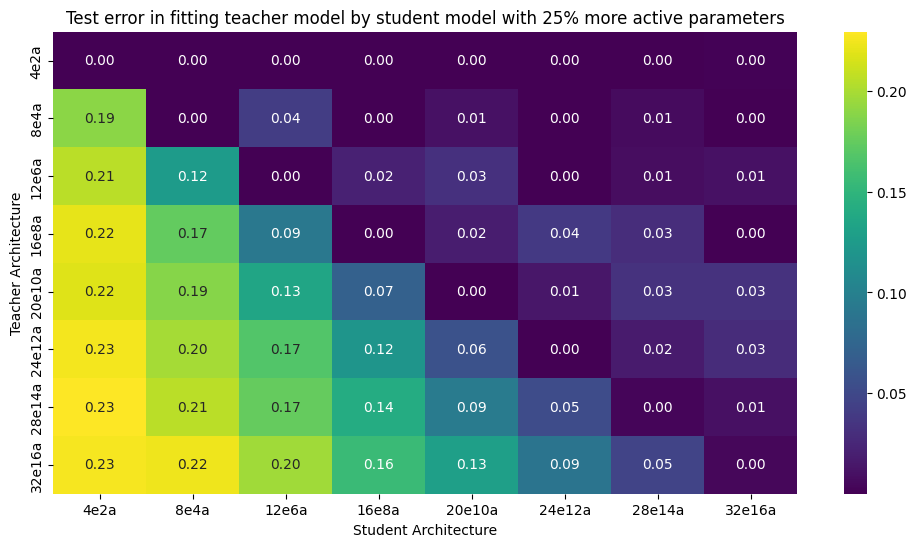

0.0012710432317314863
0.0007774244922749316
0.0021244319903083566
0.0007210240601080659
0.0012343298957921557
0.0006980970841651724
0.001958090516058834
0.0076753545695368445
0.8612552506179056
1.6723131012180287e-06
0.18679345716001416
0.000829236419385056
0.04842100268656774
0.00021176319492865447
0.031567889434138394
0.0005296064264650521
0.9363092489798066
0.5669587648581337
0.0002914828862339999
0.09629076683665451
0.14433200371942406
0.0005604326324980406
0.03549867303472543
0.04734096198969923
1.0031906796807426
0.7943534528793762
0.41690489575827605
0.0003067872873999076
0.08206283608786082
0.17306900697245042
0.13232650954725686
0.0007796658460610815
0.99407197367296
0.8526301598816773
0.6116360599292721
0.320830093546107
0.00042931289568798943
0.06341551612337305
0.14702887114318067
0.14758298842577022
1.0243567163447214
0.9036883842139383
0.7597976105695067
0.5430513170187633
0.26191056280190744
0.001144145822427677
0.07722044792833312
0.12990724356982591
1.043442236235873
0

/tmp/ipykernel_2222355/1732597821.py:108: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("viridis")


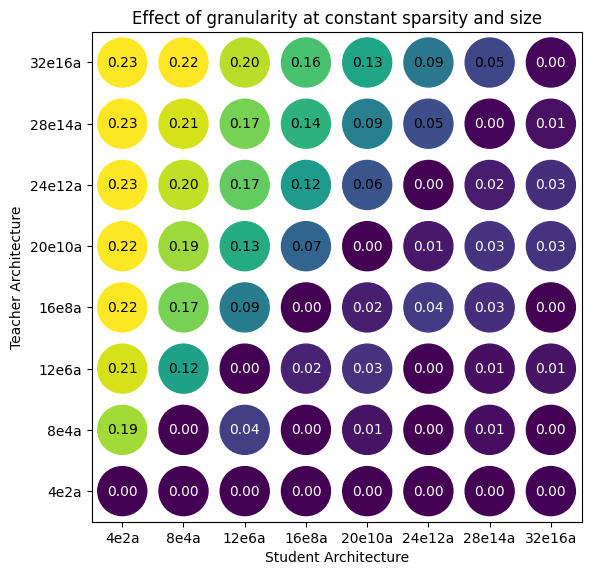

In [3]:
# Factor of 1.25 overparametrization in student model
d = 256
active_neurons1 = 256
active_neurons2 = 320

batch_size = 2048
lr = 1e-3
# lr = 3e-4
# lr = 3e-3
lr = 1e-2
num_epochs = 100
trial = 0
generate_srun = False
data_dict = {}
for num_experts2, k2 in [(4,2),(8,4),(12,6),(16,8),(20,10),(24,12),(28,14),(32,16)]:
    for num_experts1, k1 in [(4,2),(8,4),(12,6),(16,8),(20,10),(24,12),(28,14),(32,16)]:
        vals_lr = {}
        for lr in [1e-3, 1e-2]:
            vals_lr[lr] = []
            for trial in range(1):
                if generate_srun:
                    print(f'srun python moe_student_teacher.py --d {d} \
                        --k1 {k1} --num_experts1 {num_experts1} --active_neurons1 {active_neurons1} \
                        --k2 {k2} --num_experts2 {num_experts2} --active_neurons2 {active_neurons2} \
                        --num_epochs {num_epochs} \
                        --lr {lr} \
                        --batch_size {batch_size} \
                        --trial {trial}')
                else:
                    datum = generate_datapoint(d,
                                    k1,num_experts1,active_neurons1,
                                    k2,num_experts2,active_neurons2,
                                    num_epochs,lr,batch_size,
                                    trial=0)
                    val = datum['test_losses'][-1] / datum['base_losses'][-1]
                    vals_lr[lr].append(val)
        data_dict[((num_experts1,k1),(num_experts2,k2))] = vals_lr
            
import seaborn as sns
import pandas as pd
import numpy as np

print(data_dict)
processed_data_dict = {}
for k in data_dict.keys():
    bestmean = float('inf')
    for lr in data_dict[k].keys():
        if sum(data_dict[k][lr]) / len(data_dict[k][lr]) < bestmean:
            bestmean = sum(data_dict[k][lr]) / len(data_dict[k][lr])
    processed_data_dict[k] = bestmean


student_labels = [(4,2),(8,4),(12,6),(16,8),(20,10),(24,12),(28,14),(32,16)]
teacher_labels = [(4,2),(8,4),(12,6),(16,8),(20,10),(24,12),(28,14),(32,16)]
raw_data = np.zeros((len(student_labels), len(teacher_labels)))
for i, student in enumerate(student_labels):
    for j, teacher in enumerate(teacher_labels):
        if (teacher, student) in processed_data_dict.keys():
            raw_data[i,j] = processed_data_dict[(teacher, student)]
        else:
            raw_data[i,j] = float('inf')

# print(raw_data)


import matplotlib.pyplot as plt

# Convert raw_data into a DataFrame for heatmap plotting
heatmap_df = pd.DataFrame(raw_data, index=[f'{label[0]}e{label[1]}a' for label in student_labels], columns=[f'{label[0]}e{label[1]}a' for label in teacher_labels])

# print(heatmap_df)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_df.T, annot=True, fmt=".2f", cmap="viridis") # , cbar_kws={'label': 'Test error'}
plt.title("Test error in fitting teacher model by student model with 25% more active parameters")
plt.xlabel("Student Architecture")
plt.ylabel("Teacher Architecture")
plt.gcf().set_size_inches(12, 6)
plt.show()



import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap

# Data from the image (test errors)
# data = np.array([
#     [0.00, 0.00, 0.00, 0.00],
#     [0.19, 0.00, 0.00, 0.00],
#     [0.22, 0.17, 0.00, 0.00],
#     [0.23, 0.22, 0.16, 0.00],   
# ])

data = raw_data
data = np.array(data).T

rows, cols = data.shape
labels_x = [f'{label[0]}e{label[1]}a' for label in student_labels]
labels_y = [f'{label[0]}e{label[1]}a' for label in teacher_labels]
labels_y = labels_y[::-1]  # Reverse the y-axis labels

fig, ax = plt.subplots(figsize=(6, 6))
norm = Normalize(vmin=0, vmax=0.22)
cmap = get_cmap("viridis")

# Plot grid of circles
for i in range(rows):
    for j in range(cols):
        val = data[i, j]
        color = cmap(norm(val))
        print(norm(val))
        text_color = 'black' if norm(val) > 0.2 else 'white'
        circle = patches.Circle((j, rows - i - 1), 0.4, color=color)
        ax.add_patch(circle)
        ax.text(j, rows - i - 1, f"{val:.2f}", ha='center', va='center', color=text_color, fontsize=10)

# Set axes
ax.set_xlim(-0.5, cols - 0.5)
ax.set_ylim(-0.5, rows - 0.5)
ax.set_xticks(range(cols))
ax.set_yticks(range(rows))
ax.set_xticklabels(labels_x)
ax.set_yticklabels(labels_y)
ax.set_xlabel("Student Architecture")
ax.set_ylabel("Teacher Architecture")
ax.set_title("Effect of granularity at constant sparsity and size")
ax.set_aspect('equal')
ax.invert_yaxis()

plt.tight_layout()
plt.show()



# Learn 16e8a model with different granularities

In [ ]:
# Factor of 25% overparametrization in student model
d = 256
active_neurons1 = 256
active_neurons2 = 320

batch_size = 2048
num_epochs = 100
trial = 0
generate_srun = False
data_dict = {}
# for num_experts2, k2 in [(64,16),(32,8), (16,4), (8,2)]:
#     for num_experts1, k1 in [(64,16),(32,8),(16,4),(8,2)]:
student_configs = []
for granularity in [8,2,4,6]:
    for sparsity in [32,2,4,8,16]:
        student_configs.append((sparsity*granularity,granularity))

for num_experts2, k2 in student_configs:
    for num_experts1, k1 in [(16,8)]:
        vals_lr = {}
        for lr in [1e-3, 1e-2]:
            vals_lr[lr] = []
            for trial in range(1):
                if generate_srun:
                    print(f'srun python moe_student_teacher.py --d {d} \
                        --k1 {k1} --num_experts1 {num_experts1} --active_neurons1 {active_neurons1} \
                        --k2 {k2} --num_experts2 {num_experts2} --active_neurons2 {active_neurons2} \
                        --num_epochs {num_epochs} \
                        --lr {lr} \
                        --batch_size {batch_size} \
                        --trial {trial}')
                else:
                    datum = generate_datapoint(d,
                                    k1,num_experts1,active_neurons1,
                                    k2,num_experts2,active_neurons2,
                                    num_epochs,lr,batch_size,
                                    trial=0)
                    val = datum['test_losses'][-1] / datum['base_losses'][-1]
                    vals_lr[lr].append(val)
        data_dict[((num_experts1,k1),(num_experts2,k2))] = vals_lr


import seaborn as sns
import pandas as pd
import numpy as np

print(data_dict)
processed_data_dict = {}
for k in data_dict.keys():
    bestmean = float('inf')
    for lr in data_dict[k].keys():
        if sum(data_dict[k][lr]) / len(data_dict[k][lr]) < bestmean:
            bestmean = sum(data_dict[k][lr]) / len(data_dict[k][lr])
    processed_data_dict[k] = bestmean


student_labels = student_configs
teacher_labels = [(16,8)]
raw_data = np.zeros((len(student_labels), len(teacher_labels)))
for i, student in enumerate(student_labels):
    for j, teacher in enumerate(teacher_labels):
        print((student,teacher))
        if (teacher, student) in processed_data_dict.keys():
            raw_data[i,j] = processed_data_dict[(teacher, student)]
        else:
            raw_data[i,j] = float('inf')

print(raw_data)


import matplotlib.pyplot as plt

# Convert raw_data into a DataFrame for heatmap plotting
heatmap_df = pd.DataFrame(raw_data, index=[f'{label[0]}e{label[1]}a' for label in student_labels], columns=[f'{label[0]}e{label[1]}a' for label in teacher_labels])

print(heatmap_df)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_df.T, annot=True, fmt=".2f", cmap="viridis") # , cbar_kws={'label': 'Test error'}
plt.title("Fitting teacher model with larger students that have roughly the same number of active neurons")
plt.xlabel("Student Architecture")
plt.ylabel("Teacher Architecture")
plt.gcf().set_size_inches(12, 6)
plt.show()





Experiment file experiment_data/d256_16e8a256s_256e8a320s_lr0.001_b2048_e100_trial0.pkl already exists. Loading data.
Experiment file experiment_data/d256_16e8a256s_256e8a320s_lr0.01_b2048_e100_trial0.pkl already exists. Loading data.
Experiment file experiment_data/d256_16e8a256s_16e8a320s_lr0.001_b2048_e100_trial0.pkl already exists. Loading data.
Experiment file experiment_data/d256_16e8a256s_16e8a320s_lr0.01_b2048_e100_trial0.pkl already exists. Loading data.
Experiment file experiment_data/d256_16e8a256s_32e8a320s_lr0.001_b2048_e100_trial0.pkl already exists. Loading data.
Generating teacher model with 8 / 16 experts and 256 active neurons
Training student model with 8 / 32 experts and 320 active neurons


  0%|                                                                                                  | 0/100 [00:00<?, ?it/s]

Generating train and test for epoch 0


  1%|▉                                                                                         | 1/100 [00:03<05:15,  3.18s/it]

Epoch [1/100], Train Loss: 1.0226, Test Loss: 1.0171, Base Loss: 2.3744
Generating train and test for epoch 1


  2%|█▊                                                                                        | 2/100 [00:06<05:08,  3.15s/it]

Epoch [2/100], Train Loss: 0.5349, Test Loss: 0.5371, Base Loss: 2.3721
Generating train and test for epoch 2


  3%|██▋                                                                                       | 3/100 [00:09<05:05,  3.15s/it]

Epoch [3/100], Train Loss: 0.4303, Test Loss: 0.4294, Base Loss: 2.3744
Generating train and test for epoch 3


  4%|███▌                                                                                      | 4/100 [00:12<04:57,  3.10s/it]

Epoch [4/100], Train Loss: 0.4121, Test Loss: 0.4150, Base Loss: 2.3611
Generating train and test for epoch 4


  5%|████▌                                                                                     | 5/100 [00:15<04:56,  3.12s/it]

Epoch [5/100], Train Loss: 0.4111, Test Loss: 0.4064, Base Loss: 2.3774
Generating train and test for epoch 5


  6%|█████▍                                                                                    | 6/100 [00:18<04:50,  3.09s/it]

Epoch [6/100], Train Loss: 0.4116, Test Loss: 0.4044, Base Loss: 2.3750
Generating train and test for epoch 6


  7%|██████▎                                                                                   | 7/100 [00:21<04:48,  3.10s/it]

Epoch [7/100], Train Loss: 0.4030, Test Loss: 0.4008, Base Loss: 2.3619
Generating train and test for epoch 7


  8%|███████▏                                                                                  | 8/100 [00:24<04:46,  3.11s/it]

Epoch [8/100], Train Loss: 0.3993, Test Loss: 0.3968, Base Loss: 2.3666
Generating train and test for epoch 8


  9%|████████                                                                                  | 9/100 [00:27<04:40,  3.08s/it]

Epoch [9/100], Train Loss: 0.3898, Test Loss: 0.3942, Base Loss: 2.3697
Generating train and test for epoch 9


 10%|████████▉                                                                                | 10/100 [00:31<04:38,  3.10s/it]

Epoch [10/100], Train Loss: 0.3886, Test Loss: 0.3947, Base Loss: 2.3650
Generating train and test for epoch 10


 11%|█████████▊                                                                               | 11/100 [00:34<04:33,  3.07s/it]

Epoch [11/100], Train Loss: 0.3830, Test Loss: 0.3909, Base Loss: 2.3810
Generating train and test for epoch 11


 12%|██████████▋                                                                              | 12/100 [00:37<04:32,  3.10s/it]

Epoch [12/100], Train Loss: 0.3858, Test Loss: 0.3886, Base Loss: 2.3777
Generating train and test for epoch 12


 13%|███████████▌                                                                             | 13/100 [00:40<04:30,  3.11s/it]

Epoch [13/100], Train Loss: 0.3863, Test Loss: 0.3872, Base Loss: 2.3638
Generating train and test for epoch 13


 14%|████████████▍                                                                            | 14/100 [00:43<04:25,  3.08s/it]

Epoch [14/100], Train Loss: 0.3885, Test Loss: 0.3857, Base Loss: 2.3676
Generating train and test for epoch 14


 15%|█████████████▎                                                                           | 15/100 [00:46<04:23,  3.10s/it]

Epoch [15/100], Train Loss: 0.3866, Test Loss: 0.3807, Base Loss: 2.3658
Generating train and test for epoch 15


 16%|██████████████▏                                                                          | 16/100 [00:49<04:17,  3.07s/it]

Epoch [16/100], Train Loss: 0.3796, Test Loss: 0.3825, Base Loss: 2.3827
Generating train and test for epoch 16


 17%|███████████████▏                                                                         | 17/100 [00:52<04:16,  3.09s/it]

Epoch [17/100], Train Loss: 0.3794, Test Loss: 0.3784, Base Loss: 2.3731
Generating train and test for epoch 17


 18%|████████████████                                                                         | 18/100 [00:55<04:14,  3.11s/it]

Epoch [18/100], Train Loss: 0.3775, Test Loss: 0.3761, Base Loss: 2.3573
Generating train and test for epoch 18


 19%|████████████████▉                                                                        | 19/100 [00:58<04:09,  3.08s/it]

Epoch [19/100], Train Loss: 0.3722, Test Loss: 0.3738, Base Loss: 2.3718
Generating train and test for epoch 19


 20%|█████████████████▊                                                                       | 20/100 [01:01<04:07,  3.10s/it]

Epoch [20/100], Train Loss: 0.3700, Test Loss: 0.3710, Base Loss: 2.3678
Generating train and test for epoch 20


 21%|██████████████████▋                                                                      | 21/100 [01:04<04:02,  3.07s/it]

Epoch [21/100], Train Loss: 0.3699, Test Loss: 0.3704, Base Loss: 2.3661
Generating train and test for epoch 21


 22%|███████████████████▌                                                                     | 22/100 [01:08<04:01,  3.09s/it]

Epoch [22/100], Train Loss: 0.3669, Test Loss: 0.3697, Base Loss: 2.3838
Generating train and test for epoch 22


 23%|████████████████████▍                                                                    | 23/100 [01:11<03:58,  3.10s/it]

Epoch [23/100], Train Loss: 0.3656, Test Loss: 0.3683, Base Loss: 2.3855
Generating train and test for epoch 23


 24%|█████████████████████▎                                                                   | 24/100 [01:14<03:54,  3.08s/it]

Epoch [24/100], Train Loss: 0.3600, Test Loss: 0.3652, Base Loss: 2.3652
Generating train and test for epoch 24


 25%|██████████████████████▎                                                                  | 25/100 [01:17<03:52,  3.10s/it]

Epoch [25/100], Train Loss: 0.3601, Test Loss: 0.3611, Base Loss: 2.3787
Generating train and test for epoch 25


 26%|███████████████████████▏                                                                 | 26/100 [01:20<03:47,  3.07s/it]

Epoch [26/100], Train Loss: 0.3624, Test Loss: 0.3567, Base Loss: 2.3838
Generating train and test for epoch 26


 27%|████████████████████████                                                                 | 27/100 [01:23<03:45,  3.09s/it]

Epoch [27/100], Train Loss: 0.3557, Test Loss: 0.3545, Base Loss: 2.3707
Generating train and test for epoch 27


 28%|████████████████████████▉                                                                | 28/100 [01:26<03:43,  3.11s/it]

Epoch [28/100], Train Loss: 0.3561, Test Loss: 0.3525, Base Loss: 2.3777
Generating train and test for epoch 28


 29%|█████████████████████████▊                                                               | 29/100 [01:29<03:38,  3.08s/it]

Epoch [29/100], Train Loss: 0.3515, Test Loss: 0.3544, Base Loss: 2.3810
Generating train and test for epoch 29


 30%|██████████████████████████▋                                                              | 30/100 [01:32<03:36,  3.09s/it]

Epoch [30/100], Train Loss: 0.3552, Test Loss: 0.3509, Base Loss: 2.3720
Generating train and test for epoch 30


 31%|███████████████████████████▌                                                             | 31/100 [01:35<03:31,  3.07s/it]

Epoch [31/100], Train Loss: 0.3477, Test Loss: 0.3493, Base Loss: 2.3732
Generating train and test for epoch 31


 32%|████████████████████████████▍                                                            | 32/100 [01:38<03:29,  3.09s/it]

Epoch [32/100], Train Loss: 0.3465, Test Loss: 0.3457, Base Loss: 2.3599
Generating train and test for epoch 32


 33%|█████████████████████████████▎                                                           | 33/100 [01:42<03:28,  3.11s/it]

Epoch [33/100], Train Loss: 0.3429, Test Loss: 0.3445, Base Loss: 2.3701
Generating train and test for epoch 33


 34%|██████████████████████████████▎                                                          | 34/100 [01:45<03:23,  3.08s/it]

Epoch [34/100], Train Loss: 0.3456, Test Loss: 0.3389, Base Loss: 2.3664
Generating train and test for epoch 34


 35%|███████████████████████████████▏                                                         | 35/100 [01:48<03:21,  3.10s/it]

Epoch [35/100], Train Loss: 0.3416, Test Loss: 0.3413, Base Loss: 2.3676
Generating train and test for epoch 35


 36%|████████████████████████████████                                                         | 36/100 [01:51<03:16,  3.07s/it]

Epoch [36/100], Train Loss: 0.3388, Test Loss: 0.3372, Base Loss: 2.3709
Generating train and test for epoch 36


 37%|████████████████████████████████▉                                                        | 37/100 [01:54<03:14,  3.09s/it]

Epoch [37/100], Train Loss: 0.3341, Test Loss: 0.3342, Base Loss: 2.3653
Generating train and test for epoch 37


 38%|█████████████████████████████████▊                                                       | 38/100 [01:57<03:12,  3.11s/it]

Epoch [38/100], Train Loss: 0.3306, Test Loss: 0.3312, Base Loss: 2.3519
Generating train and test for epoch 38


 39%|██████████████████████████████████▋                                                      | 39/100 [02:00<03:07,  3.08s/it]

Epoch [39/100], Train Loss: 0.3282, Test Loss: 0.3286, Base Loss: 2.3864
Generating train and test for epoch 39


 40%|███████████████████████████████████▌                                                     | 40/100 [02:03<03:05,  3.10s/it]

Epoch [40/100], Train Loss: 0.3303, Test Loss: 0.3244, Base Loss: 2.3565
Generating train and test for epoch 40


 41%|████████████████████████████████████▍                                                    | 41/100 [02:06<03:01,  3.07s/it]

Epoch [41/100], Train Loss: 0.3219, Test Loss: 0.3209, Base Loss: 2.3681
Generating train and test for epoch 41


 42%|█████████████████████████████████████▍                                                   | 42/100 [02:09<02:59,  3.09s/it]

Epoch [42/100], Train Loss: 0.3209, Test Loss: 0.3169, Base Loss: 2.3615
Generating train and test for epoch 42


 43%|██████████████████████████████████████▎                                                  | 43/100 [02:13<02:57,  3.11s/it]

Epoch [43/100], Train Loss: 0.3206, Test Loss: 0.3117, Base Loss: 2.3635
Generating train and test for epoch 43


 44%|███████████████████████████████████████▏                                                 | 44/100 [02:16<02:52,  3.08s/it]

Epoch [44/100], Train Loss: 0.2949, Test Loss: 0.3002, Base Loss: 2.3696
Generating train and test for epoch 44


 45%|████████████████████████████████████████                                                 | 45/100 [02:19<02:50,  3.09s/it]

Epoch [45/100], Train Loss: 0.2708, Test Loss: 0.2678, Base Loss: 2.3556
Generating train and test for epoch 45


 46%|████████████████████████████████████████▉                                                | 46/100 [02:22<02:45,  3.07s/it]

Epoch [46/100], Train Loss: 0.2352, Test Loss: 0.2365, Base Loss: 2.3804
Generating train and test for epoch 46


 47%|█████████████████████████████████████████▊                                               | 47/100 [02:25<02:43,  3.09s/it]

Epoch [47/100], Train Loss: 0.2180, Test Loss: 0.2239, Base Loss: 2.3631
Generating train and test for epoch 47


 48%|██████████████████████████████████████████▋                                              | 48/100 [02:28<02:41,  3.10s/it]

Epoch [48/100], Train Loss: 0.2041, Test Loss: 0.2045, Base Loss: 2.3661
Generating train and test for epoch 48


 49%|███████████████████████████████████████████▌                                             | 49/100 [02:31<02:36,  3.08s/it]

Epoch [49/100], Train Loss: 0.1986, Test Loss: 0.1959, Base Loss: 2.3623
Generating train and test for epoch 49


 50%|████████████████████████████████████████████▌                                            | 50/100 [02:34<02:34,  3.09s/it]

Epoch [50/100], Train Loss: 0.1823, Test Loss: 0.1837, Base Loss: 2.3780
Generating train and test for epoch 50


 51%|█████████████████████████████████████████████▍                                           | 51/100 [02:37<02:30,  3.07s/it]

Epoch [51/100], Train Loss: 0.1779, Test Loss: 0.1783, Base Loss: 2.3687
Generating train and test for epoch 51


 52%|██████████████████████████████████████████████▎                                          | 52/100 [02:40<02:28,  3.09s/it]

Epoch [52/100], Train Loss: 0.1690, Test Loss: 0.1667, Base Loss: 2.3534
Generating train and test for epoch 52


 53%|███████████████████████████████████████████████▏                                         | 53/100 [02:43<02:25,  3.10s/it]

Epoch [53/100], Train Loss: 0.1635, Test Loss: 0.1606, Base Loss: 2.3760
Generating train and test for epoch 53


 54%|████████████████████████████████████████████████                                         | 54/100 [02:46<02:21,  3.08s/it]

Epoch [54/100], Train Loss: 0.1585, Test Loss: 0.1603, Base Loss: 2.3822
Generating train and test for epoch 54


 55%|████████████████████████████████████████████████▉                                        | 55/100 [02:50<02:19,  3.10s/it]

Epoch [55/100], Train Loss: 0.1524, Test Loss: 0.1518, Base Loss: 2.3586
Generating train and test for epoch 55


 56%|█████████████████████████████████████████████████▊                                       | 56/100 [02:53<02:15,  3.08s/it]

Epoch [56/100], Train Loss: 0.1529, Test Loss: 0.1470, Base Loss: 2.3851
Generating train and test for epoch 56


 57%|██████████████████████████████████████████████████▋                                      | 57/100 [02:56<02:12,  3.09s/it]

Epoch [57/100], Train Loss: 0.1500, Test Loss: 0.1431, Base Loss: 2.3724
Generating train and test for epoch 57


 58%|███████████████████████████████████████████████████▌                                     | 58/100 [02:59<02:10,  3.11s/it]

Epoch [58/100], Train Loss: 0.1403, Test Loss: 0.1423, Base Loss: 2.3535
Generating train and test for epoch 58


 59%|████████████████████████████████████████████████████▌                                    | 59/100 [03:02<02:06,  3.08s/it]

Epoch [59/100], Train Loss: 0.1410, Test Loss: 0.1364, Base Loss: 2.3771
Generating train and test for epoch 59


 60%|█████████████████████████████████████████████████████▍                                   | 60/100 [03:05<02:03,  3.09s/it]

Epoch [60/100], Train Loss: 0.1309, Test Loss: 0.1390, Base Loss: 2.3790
Generating train and test for epoch 60


 61%|██████████████████████████████████████████████████████▎                                  | 61/100 [03:08<01:59,  3.07s/it]

Epoch [61/100], Train Loss: 0.1313, Test Loss: 0.1292, Base Loss: 2.3594
Generating train and test for epoch 61


 62%|███████████████████████████████████████████████████████▏                                 | 62/100 [03:11<01:57,  3.09s/it]

Epoch [62/100], Train Loss: 0.1277, Test Loss: 0.1285, Base Loss: 2.3819
Generating train and test for epoch 62


 63%|████████████████████████████████████████████████████████                                 | 63/100 [03:14<01:54,  3.10s/it]

Epoch [63/100], Train Loss: 0.1226, Test Loss: 0.1227, Base Loss: 2.3623
Generating train and test for epoch 63


 64%|████████████████████████████████████████████████████████▉                                | 64/100 [03:17<01:50,  3.07s/it]

Epoch [64/100], Train Loss: 0.1201, Test Loss: 0.1209, Base Loss: 2.3606
Generating train and test for epoch 64


 65%|█████████████████████████████████████████████████████████▊                               | 65/100 [03:20<01:48,  3.09s/it]

Epoch [65/100], Train Loss: 0.1183, Test Loss: 0.1181, Base Loss: 2.3506
Generating train and test for epoch 65


 66%|██████████████████████████████████████████████████████████▋                              | 66/100 [03:23<01:44,  3.07s/it]

Epoch [66/100], Train Loss: 0.1170, Test Loss: 0.1148, Base Loss: 2.3708
Generating train and test for epoch 66


 67%|███████████████████████████████████████████████████████████▋                             | 67/100 [03:27<01:41,  3.09s/it]

Epoch [67/100], Train Loss: 0.1151, Test Loss: 0.1131, Base Loss: 2.3745
Generating train and test for epoch 67


 68%|████████████████████████████████████████████████████████████▌                            | 68/100 [03:30<01:39,  3.10s/it]

Epoch [68/100], Train Loss: 0.1150, Test Loss: 0.1096, Base Loss: 2.3591
Generating train and test for epoch 68


 69%|█████████████████████████████████████████████████████████████▍                           | 69/100 [03:33<01:35,  3.07s/it]

Epoch [69/100], Train Loss: 0.1147, Test Loss: 0.1065, Base Loss: 2.3761
Generating train and test for epoch 69


 70%|██████████████████████████████████████████████████████████████▎                          | 70/100 [03:36<01:32,  3.10s/it]

Epoch [70/100], Train Loss: 0.1098, Test Loss: 0.1053, Base Loss: 2.3597
Generating train and test for epoch 70


 71%|███████████████████████████████████████████████████████████████▏                         | 71/100 [03:39<01:29,  3.07s/it]

Epoch [71/100], Train Loss: 0.0990, Test Loss: 0.1017, Base Loss: 2.3764
Generating train and test for epoch 71


 72%|████████████████████████████████████████████████████████████████                         | 72/100 [03:42<01:26,  3.09s/it]

Epoch [72/100], Train Loss: 0.1055, Test Loss: 0.1020, Base Loss: 2.3768
Generating train and test for epoch 72


 73%|████████████████████████████████████████████████████████████████▉                        | 73/100 [03:45<01:23,  3.10s/it]

Epoch [73/100], Train Loss: 0.0999, Test Loss: 0.0990, Base Loss: 2.3569
Generating train and test for epoch 73


 74%|█████████████████████████████████████████████████████████████████▊                       | 74/100 [03:48<01:19,  3.07s/it]

Epoch [74/100], Train Loss: 0.1006, Test Loss: 0.0999, Base Loss: 2.3794
Generating train and test for epoch 74


 75%|██████████████████████████████████████████████████████████████████▊                      | 75/100 [03:51<01:17,  3.09s/it]

Epoch [75/100], Train Loss: 0.0955, Test Loss: 0.0966, Base Loss: 2.3569
Generating train and test for epoch 75


 76%|███████████████████████████████████████████████████████████████████▋                     | 76/100 [03:54<01:13,  3.07s/it]

Epoch [76/100], Train Loss: 0.0938, Test Loss: 0.0951, Base Loss: 2.3594
Generating train and test for epoch 76


 77%|████████████████████████████████████████████████████████████████████▌                    | 77/100 [03:57<01:10,  3.09s/it]

Epoch [77/100], Train Loss: 0.0923, Test Loss: 0.0919, Base Loss: 2.3584
Generating train and test for epoch 77


 78%|█████████████████████████████████████████████████████████████████████▍                   | 78/100 [04:01<01:08,  3.10s/it]

Epoch [78/100], Train Loss: 0.0926, Test Loss: 0.0882, Base Loss: 2.3699
Generating train and test for epoch 78


 79%|██████████████████████████████████████████████████████████████████████▎                  | 79/100 [04:04<01:04,  3.08s/it]

Epoch [79/100], Train Loss: 0.0843, Test Loss: 0.0881, Base Loss: 2.3739
Generating train and test for epoch 79


 80%|███████████████████████████████████████████████████████████████████████▏                 | 80/100 [04:07<01:01,  3.10s/it]

Epoch [80/100], Train Loss: 0.0829, Test Loss: 0.0817, Base Loss: 2.3790
Generating train and test for epoch 80


 81%|████████████████████████████████████████████████████████████████████████                 | 81/100 [04:10<00:58,  3.07s/it]

Epoch [81/100], Train Loss: 0.0848, Test Loss: 0.0791, Base Loss: 2.3563
Generating train and test for epoch 81


 82%|████████████████████████████████████████████████████████████████████████▉                | 82/100 [04:13<00:55,  3.09s/it]

Epoch [82/100], Train Loss: 0.0834, Test Loss: 0.0839, Base Loss: 2.3673
Generating train and test for epoch 82


 83%|█████████████████████████████████████████████████████████████████████████▊               | 83/100 [04:16<00:52,  3.10s/it]

Epoch [83/100], Train Loss: 0.0778, Test Loss: 0.0818, Base Loss: 2.3681
Generating train and test for epoch 83


 84%|██████████████████████████████████████████████████████████████████████████▊              | 84/100 [04:19<00:49,  3.07s/it]

Epoch [84/100], Train Loss: 0.0779, Test Loss: 0.0812, Base Loss: 2.3735
Generating train and test for epoch 84


 85%|███████████████████████████████████████████████████████████████████████████▋             | 85/100 [04:22<00:46,  3.09s/it]

Epoch [85/100], Train Loss: 0.0786, Test Loss: 0.0813, Base Loss: 2.3883
Generating train and test for epoch 85


 86%|████████████████████████████████████████████████████████████████████████████▌            | 86/100 [04:25<00:42,  3.07s/it]

Epoch [86/100], Train Loss: 0.0765, Test Loss: 0.0820, Base Loss: 2.3696
Generating train and test for epoch 86


 87%|█████████████████████████████████████████████████████████████████████████████▍           | 87/100 [04:28<00:40,  3.09s/it]

Epoch [87/100], Train Loss: 0.0793, Test Loss: 0.0791, Base Loss: 2.3717
Generating train and test for epoch 87


 88%|██████████████████████████████████████████████████████████████████████████████▎          | 88/100 [04:31<00:37,  3.11s/it]

Epoch [88/100], Train Loss: 0.0687, Test Loss: 0.0763, Base Loss: 2.3683
Generating train and test for epoch 88


 89%|███████████████████████████████████████████████████████████████████████████████▏         | 89/100 [04:34<00:33,  3.08s/it]

Epoch [89/100], Train Loss: 0.0712, Test Loss: 0.0757, Base Loss: 2.3745
Generating train and test for epoch 89


 90%|████████████████████████████████████████████████████████████████████████████████         | 90/100 [04:38<00:30,  3.09s/it]

Epoch [90/100], Train Loss: 0.0760, Test Loss: 0.0725, Base Loss: 2.3809
Generating train and test for epoch 90


 91%|████████████████████████████████████████████████████████████████████████████████▉        | 91/100 [04:41<00:27,  3.07s/it]

Epoch [91/100], Train Loss: 0.0683, Test Loss: 0.0724, Base Loss: 2.3686
Generating train and test for epoch 91


 92%|█████████████████████████████████████████████████████████████████████████████████▉       | 92/100 [04:44<00:24,  3.09s/it]

Epoch [92/100], Train Loss: 0.0730, Test Loss: 0.0703, Base Loss: 2.3833
Generating train and test for epoch 92


 93%|██████████████████████████████████████████████████████████████████████████████████▊      | 93/100 [04:47<00:21,  3.10s/it]

Epoch [93/100], Train Loss: 0.0696, Test Loss: 0.0718, Base Loss: 2.3702
Generating train and test for epoch 93


 94%|███████████████████████████████████████████████████████████████████████████████████▋     | 94/100 [04:50<00:18,  3.07s/it]

Epoch [94/100], Train Loss: 0.0683, Test Loss: 0.0700, Base Loss: 2.3539
Generating train and test for epoch 94


 95%|████████████████████████████████████████████████████████████████████████████████████▌    | 95/100 [04:53<00:15,  3.10s/it]

Epoch [95/100], Train Loss: 0.0715, Test Loss: 0.0684, Base Loss: 2.3904
Generating train and test for epoch 95


 96%|█████████████████████████████████████████████████████████████████████████████████████▍   | 96/100 [04:56<00:12,  3.07s/it]

Epoch [96/100], Train Loss: 0.0682, Test Loss: 0.0699, Base Loss: 2.3728
Generating train and test for epoch 96


 97%|██████████████████████████████████████████████████████████████████████████████████████▎  | 97/100 [04:59<00:09,  3.09s/it]

Epoch [97/100], Train Loss: 0.0660, Test Loss: 0.0654, Base Loss: 2.3699
Generating train and test for epoch 97


 98%|███████████████████████████████████████████████████████████████████████████████████████▏ | 98/100 [05:02<00:06,  3.10s/it]

Epoch [98/100], Train Loss: 0.0685, Test Loss: 0.0662, Base Loss: 2.3590
Generating train and test for epoch 98


 99%|████████████████████████████████████████████████████████████████████████████████████████ | 99/100 [05:05<00:03,  3.07s/it]

Epoch [99/100], Train Loss: 0.0670, Test Loss: 0.0662, Base Loss: 2.3751
Generating train and test for epoch 99


100%|████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:08<00:00,  3.09s/it]


Epoch [100/100], Train Loss: 0.0660, Test Loss: 0.0690, Base Loss: 2.3783
Generating teacher model with 8 / 16 experts and 256 active neurons
Training student model with 8 / 64 experts and 320 active neurons


  0%|                                                                                                  | 0/100 [00:00<?, ?it/s]

Generating train and test for epoch 0


  1%|▉                                                                                         | 1/100 [00:04<07:00,  4.25s/it]

Epoch [1/100], Train Loss: 1.4876, Test Loss: 1.4779, Base Loss: 2.4751
Generating train and test for epoch 1


  2%|█▊                                                                                        | 2/100 [00:08<06:55,  4.24s/it]

Epoch [2/100], Train Loss: 1.1284, Test Loss: 1.1258, Base Loss: 2.4728
Generating train and test for epoch 2


  3%|██▋                                                                                       | 3/100 [00:12<06:46,  4.19s/it]

Epoch [3/100], Train Loss: 0.8253, Test Loss: 0.8202, Base Loss: 2.4834
Generating train and test for epoch 3


  4%|███▌                                                                                      | 4/100 [00:16<06:48,  4.25s/it]

Epoch [4/100], Train Loss: 0.6202, Test Loss: 0.6152, Base Loss: 2.4807
Generating train and test for epoch 4


  5%|████▌                                                                                     | 5/100 [00:20<06:35,  4.16s/it]

Epoch [5/100], Train Loss: 0.4926, Test Loss: 0.4893, Base Loss: 2.4796
Generating train and test for epoch 5


  6%|█████▍                                                                                    | 6/100 [00:25<06:34,  4.19s/it]

Epoch [6/100], Train Loss: 0.3811, Test Loss: 0.3840, Base Loss: 2.4698
Generating train and test for epoch 6


  7%|██████▎                                                                                   | 7/100 [00:29<06:31,  4.21s/it]

Epoch [7/100], Train Loss: 0.3141, Test Loss: 0.3139, Base Loss: 2.4886
Generating train and test for epoch 7


  8%|███████▏                                                                                  | 8/100 [00:33<06:24,  4.18s/it]

Epoch [8/100], Train Loss: 0.2743, Test Loss: 0.2723, Base Loss: 2.4774
Generating train and test for epoch 8


  9%|████████                                                                                  | 9/100 [00:37<06:21,  4.20s/it]

Epoch [9/100], Train Loss: 0.2522, Test Loss: 0.2538, Base Loss: 2.4793
Generating train and test for epoch 9


 10%|████████▉                                                                                | 10/100 [00:41<06:15,  4.17s/it]

Epoch [10/100], Train Loss: 0.2409, Test Loss: 0.2401, Base Loss: 2.4664
Generating train and test for epoch 10


 11%|█████████▊                                                                               | 11/100 [00:46<06:13,  4.19s/it]

Epoch [11/100], Train Loss: 0.2382, Test Loss: 0.2381, Base Loss: 2.4732
Generating train and test for epoch 11


 12%|██████████▋                                                                              | 12/100 [00:50<06:10,  4.20s/it]

Epoch [12/100], Train Loss: 0.2319, Test Loss: 0.2350, Base Loss: 2.4797
Generating train and test for epoch 12


 13%|███████████▌                                                                             | 13/100 [00:54<06:03,  4.18s/it]

Epoch [13/100], Train Loss: 0.2341, Test Loss: 0.2332, Base Loss: 2.4797
Generating train and test for epoch 13


 14%|████████████▍                                                                            | 14/100 [00:58<06:00,  4.20s/it]

Epoch [14/100], Train Loss: 0.2364, Test Loss: 0.2316, Base Loss: 2.4696
Generating train and test for epoch 14


 15%|█████████████▎                                                                           | 15/100 [01:02<05:55,  4.18s/it]

Epoch [15/100], Train Loss: 0.2372, Test Loss: 0.2349, Base Loss: 2.4739
Generating train and test for epoch 15


 16%|██████████████▏                                                                          | 16/100 [01:07<05:52,  4.19s/it]

Epoch [16/100], Train Loss: 0.2335, Test Loss: 0.2328, Base Loss: 2.4930
Generating train and test for epoch 16


 17%|███████████████▏                                                                         | 17/100 [01:11<05:49,  4.21s/it]

Epoch [17/100], Train Loss: 0.2307, Test Loss: 0.2331, Base Loss: 2.4832
Generating train and test for epoch 17


 18%|████████████████                                                                         | 18/100 [01:15<05:42,  4.18s/it]

Epoch [18/100], Train Loss: 0.2342, Test Loss: 0.2311, Base Loss: 2.4806
Generating train and test for epoch 18


 19%|████████████████▉                                                                        | 19/100 [01:19<05:39,  4.20s/it]

Epoch [19/100], Train Loss: 0.2307, Test Loss: 0.2305, Base Loss: 2.4828
Generating train and test for epoch 19


 20%|█████████████████▊                                                                       | 20/100 [01:23<05:33,  4.17s/it]

Epoch [20/100], Train Loss: 0.2308, Test Loss: 0.2338, Base Loss: 2.4740
Generating train and test for epoch 20


 21%|██████████████████▋                                                                      | 21/100 [01:28<05:31,  4.19s/it]

Epoch [21/100], Train Loss: 0.2358, Test Loss: 0.2331, Base Loss: 2.4931
Generating train and test for epoch 21


 22%|███████████████████▌                                                                     | 22/100 [01:32<05:28,  4.21s/it]

Epoch [22/100], Train Loss: 0.2382, Test Loss: 0.2319, Base Loss: 2.4804
Generating train and test for epoch 22


 23%|████████████████████▍                                                                    | 23/100 [01:36<05:22,  4.19s/it]

Epoch [23/100], Train Loss: 0.2345, Test Loss: 0.2307, Base Loss: 2.4676
Generating train and test for epoch 23


 24%|█████████████████████▎                                                                   | 24/100 [01:40<05:19,  4.20s/it]

Epoch [24/100], Train Loss: 0.2297, Test Loss: 0.2351, Base Loss: 2.4812
Generating train and test for epoch 24


 25%|██████████████████████▎                                                                  | 25/100 [01:44<05:13,  4.18s/it]

Epoch [25/100], Train Loss: 0.2310, Test Loss: 0.2322, Base Loss: 2.4752
Generating train and test for epoch 25


 26%|███████████████████████▏                                                                 | 26/100 [01:49<05:10,  4.19s/it]

Epoch [26/100], Train Loss: 0.2335, Test Loss: 0.2305, Base Loss: 2.4901
Generating train and test for epoch 26


 27%|████████████████████████                                                                 | 27/100 [01:53<05:07,  4.21s/it]

Epoch [27/100], Train Loss: 0.2325, Test Loss: 0.2301, Base Loss: 2.4815
Generating train and test for epoch 27


 28%|████████████████████████▉                                                                | 28/100 [01:57<05:00,  4.18s/it]

Epoch [28/100], Train Loss: 0.2314, Test Loss: 0.2310, Base Loss: 2.4702
Generating train and test for epoch 28


 29%|█████████████████████████▊                                                               | 29/100 [02:01<04:58,  4.20s/it]

Epoch [29/100], Train Loss: 0.2297, Test Loss: 0.2293, Base Loss: 2.4784
Generating train and test for epoch 29


 30%|██████████████████████████▋                                                              | 30/100 [02:05<04:52,  4.18s/it]

Epoch [30/100], Train Loss: 0.2284, Test Loss: 0.2312, Base Loss: 2.4619
Generating train and test for epoch 30


 31%|███████████████████████████▌                                                             | 31/100 [02:09<04:49,  4.20s/it]

Epoch [31/100], Train Loss: 0.2282, Test Loss: 0.2302, Base Loss: 2.4797
Generating train and test for epoch 31


 32%|████████████████████████████▍                                                            | 32/100 [02:14<04:46,  4.21s/it]

Epoch [32/100], Train Loss: 0.2261, Test Loss: 0.2282, Base Loss: 2.4798
Generating train and test for epoch 32


 33%|█████████████████████████████▎                                                           | 33/100 [02:18<04:40,  4.18s/it]

Epoch [33/100], Train Loss: 0.2273, Test Loss: 0.2276, Base Loss: 2.4671
Generating train and test for epoch 33


 34%|██████████████████████████████▎                                                          | 34/100 [02:22<04:36,  4.20s/it]

Epoch [34/100], Train Loss: 0.2281, Test Loss: 0.2272, Base Loss: 2.4913
Generating train and test for epoch 34


 35%|███████████████████████████████▏                                                         | 35/100 [02:26<04:31,  4.17s/it]

Epoch [35/100], Train Loss: 0.2263, Test Loss: 0.2262, Base Loss: 2.4783
Generating train and test for epoch 35


 36%|████████████████████████████████                                                         | 36/100 [02:30<04:28,  4.19s/it]

Epoch [36/100], Train Loss: 0.2257, Test Loss: 0.2253, Base Loss: 2.4717
Generating train and test for epoch 36


 37%|████████████████████████████████▉                                                        | 37/100 [02:35<04:24,  4.20s/it]

Epoch [37/100], Train Loss: 0.2280, Test Loss: 0.2257, Base Loss: 2.4691
Generating train and test for epoch 37


 38%|█████████████████████████████████▊                                                       | 38/100 [02:39<04:18,  4.18s/it]

Epoch [38/100], Train Loss: 0.2254, Test Loss: 0.2283, Base Loss: 2.4849
Generating train and test for epoch 38


 39%|██████████████████████████████████▋                                                      | 39/100 [02:43<04:16,  4.20s/it]

Epoch [39/100], Train Loss: 0.2261, Test Loss: 0.2266, Base Loss: 2.4680
Generating train and test for epoch 39


 40%|███████████████████████████████████▌                                                     | 40/100 [02:47<04:10,  4.18s/it]

Epoch [40/100], Train Loss: 0.2265, Test Loss: 0.2245, Base Loss: 2.4846
Generating train and test for epoch 40


 41%|████████████████████████████████████▍                                                    | 41/100 [02:51<04:05,  4.16s/it]

Epoch [41/100], Train Loss: 0.2270, Test Loss: 0.2255, Base Loss: 2.4624
Generating train and test for epoch 41


 42%|█████████████████████████████████████▍                                                   | 42/100 [02:56<04:04,  4.21s/it]

Epoch [42/100], Train Loss: 0.2245, Test Loss: 0.2260, Base Loss: 2.4764
Generating train and test for epoch 42


 43%|██████████████████████████████████████▎                                                  | 43/100 [03:00<03:58,  4.18s/it]

Epoch [43/100], Train Loss: 0.2249, Test Loss: 0.2237, Base Loss: 2.4745
Generating train and test for epoch 43


 44%|███████████████████████████████████████▏                                                 | 44/100 [03:04<03:55,  4.20s/it]

Epoch [44/100], Train Loss: 0.2234, Test Loss: 0.2245, Base Loss: 2.4586
Generating train and test for epoch 44


 45%|████████████████████████████████████████                                                 | 45/100 [03:08<03:49,  4.18s/it]

Epoch [45/100], Train Loss: 0.2236, Test Loss: 0.2240, Base Loss: 2.4583
Generating train and test for epoch 45


 46%|████████████████████████████████████████▉                                                | 46/100 [03:12<03:44,  4.16s/it]

Epoch [46/100], Train Loss: 0.2215, Test Loss: 0.2202, Base Loss: 2.4775
Generating train and test for epoch 46


 47%|█████████████████████████████████████████▊                                               | 47/100 [03:17<03:43,  4.22s/it]

Epoch [47/100], Train Loss: 0.2263, Test Loss: 0.2245, Base Loss: 2.4831
Generating train and test for epoch 47


 48%|██████████████████████████████████████████▋                                              | 48/100 [03:21<03:37,  4.19s/it]

Epoch [48/100], Train Loss: 0.2223, Test Loss: 0.2235, Base Loss: 2.4888
Generating train and test for epoch 48


 49%|███████████████████████████████████████████▌                                             | 49/100 [03:25<03:34,  4.20s/it]

Epoch [49/100], Train Loss: 0.2195, Test Loss: 0.2201, Base Loss: 2.4778
Generating train and test for epoch 49


 50%|████████████████████████████████████████████▌                                            | 50/100 [03:29<03:28,  4.18s/it]

Epoch [50/100], Train Loss: 0.2209, Test Loss: 0.2212, Base Loss: 2.4620
Generating train and test for epoch 50


 51%|█████████████████████████████████████████████▍                                           | 51/100 [03:33<03:23,  4.16s/it]

Epoch [51/100], Train Loss: 0.2220, Test Loss: 0.2202, Base Loss: 2.4761
Generating train and test for epoch 51


 52%|██████████████████████████████████████████████▎                                          | 52/100 [03:37<03:22,  4.22s/it]

Epoch [52/100], Train Loss: 0.2201, Test Loss: 0.2218, Base Loss: 2.4727
Generating train and test for epoch 52


 53%|███████████████████████████████████████████████▏                                         | 53/100 [03:42<03:16,  4.18s/it]

Epoch [53/100], Train Loss: 0.2196, Test Loss: 0.2232, Base Loss: 2.4850
Generating train and test for epoch 53


 54%|████████████████████████████████████████████████                                         | 54/100 [03:46<03:11,  4.17s/it]

Epoch [54/100], Train Loss: 0.2198, Test Loss: 0.2221, Base Loss: 2.4926
Generating train and test for epoch 54


 55%|████████████████████████████████████████████████▉                                        | 55/100 [03:50<03:08,  4.19s/it]

Epoch [55/100], Train Loss: 0.2205, Test Loss: 0.2223, Base Loss: 2.4799
Generating train and test for epoch 55


 56%|█████████████████████████████████████████████████▊                                       | 56/100 [03:54<03:03,  4.17s/it]

Epoch [56/100], Train Loss: 0.2212, Test Loss: 0.2178, Base Loss: 2.4849
Generating train and test for epoch 56


 57%|██████████████████████████████████████████████████▋                                      | 57/100 [03:58<03:01,  4.22s/it]

Epoch [57/100], Train Loss: 0.2213, Test Loss: 0.2181, Base Loss: 2.4808
Generating train and test for epoch 57


 58%|███████████████████████████████████████████████████▌                                     | 58/100 [04:03<02:56,  4.19s/it]

Epoch [58/100], Train Loss: 0.2207, Test Loss: 0.2193, Base Loss: 2.4760
Generating train and test for epoch 58


 59%|████████████████████████████████████████████████████▌                                    | 59/100 [04:07<02:51,  4.17s/it]

Epoch [59/100], Train Loss: 0.2205, Test Loss: 0.2202, Base Loss: 2.4757
Generating train and test for epoch 59


 60%|█████████████████████████████████████████████████████▍                                   | 60/100 [04:11<02:47,  4.19s/it]

Epoch [60/100], Train Loss: 0.2181, Test Loss: 0.2193, Base Loss: 2.4770
Generating train and test for epoch 60


 61%|██████████████████████████████████████████████████████▎                                  | 61/100 [04:15<02:42,  4.17s/it]

Epoch [61/100], Train Loss: 0.2195, Test Loss: 0.2202, Base Loss: 2.4732
Generating train and test for epoch 61


 62%|███████████████████████████████████████████████████████▏                                 | 62/100 [04:19<02:40,  4.22s/it]

Epoch [62/100], Train Loss: 0.2165, Test Loss: 0.2182, Base Loss: 2.4816
Generating train and test for epoch 62


 63%|████████████████████████████████████████████████████████                                 | 63/100 [04:23<02:33,  4.15s/it]

Epoch [63/100], Train Loss: 0.2160, Test Loss: 0.2192, Base Loss: 2.4674
Generating train and test for epoch 63


 64%|████████████████████████████████████████████████████████▉                                | 64/100 [04:28<02:30,  4.18s/it]

Epoch [64/100], Train Loss: 0.2184, Test Loss: 0.2190, Base Loss: 2.4830
Generating train and test for epoch 64


 65%|█████████████████████████████████████████████████████████▊                               | 65/100 [04:32<02:26,  4.19s/it]

Epoch [65/100], Train Loss: 0.2195, Test Loss: 0.2176, Base Loss: 2.4629
Generating train and test for epoch 65


 66%|██████████████████████████████████████████████████████████▋                              | 66/100 [04:36<02:21,  4.17s/it]

Epoch [66/100], Train Loss: 0.2179, Test Loss: 0.2186, Base Loss: 2.4690
Generating train and test for epoch 66


 67%|███████████████████████████████████████████████████████████▋                             | 67/100 [04:40<02:19,  4.23s/it]

Epoch [67/100], Train Loss: 0.2197, Test Loss: 0.2189, Base Loss: 2.4858
Generating train and test for epoch 67


 68%|████████████████████████████████████████████████████████████▌                            | 68/100 [04:44<02:12,  4.15s/it]

Epoch [68/100], Train Loss: 0.2219, Test Loss: 0.2181, Base Loss: 2.4521
Generating train and test for epoch 68


 69%|█████████████████████████████████████████████████████████████▍                           | 69/100 [04:49<02:09,  4.18s/it]

Epoch [69/100], Train Loss: 0.2156, Test Loss: 0.2174, Base Loss: 2.4788
Generating train and test for epoch 69


 70%|██████████████████████████████████████████████████████████████▎                          | 70/100 [04:53<02:05,  4.19s/it]

Epoch [70/100], Train Loss: 0.2183, Test Loss: 0.2173, Base Loss: 2.4722
Generating train and test for epoch 70


 71%|███████████████████████████████████████████████████████████████▏                         | 71/100 [04:57<02:00,  4.17s/it]

Epoch [71/100], Train Loss: 0.2189, Test Loss: 0.2176, Base Loss: 2.4853
Generating train and test for epoch 71


 72%|████████████████████████████████████████████████████████████████                         | 72/100 [05:01<01:58,  4.22s/it]

Epoch [72/100], Train Loss: 0.2149, Test Loss: 0.2185, Base Loss: 2.4670
Generating train and test for epoch 72


 73%|████████████████████████████████████████████████████████████████▉                        | 73/100 [05:05<01:52,  4.16s/it]

Epoch [73/100], Train Loss: 0.2177, Test Loss: 0.2170, Base Loss: 2.4848
Generating train and test for epoch 73


 74%|█████████████████████████████████████████████████████████████████▊                       | 74/100 [05:09<01:48,  4.19s/it]

Epoch [74/100], Train Loss: 0.2172, Test Loss: 0.2172, Base Loss: 2.4729
Generating train and test for epoch 74


 75%|██████████████████████████████████████████████████████████████████▊                      | 75/100 [05:14<01:45,  4.20s/it]

Epoch [75/100], Train Loss: 0.2166, Test Loss: 0.2177, Base Loss: 2.4735
Generating train and test for epoch 75


 76%|███████████████████████████████████████████████████████████████████▋                     | 76/100 [05:18<01:40,  4.17s/it]

Epoch [76/100], Train Loss: 0.2158, Test Loss: 0.2167, Base Loss: 2.4894
Generating train and test for epoch 76


 77%|████████████████████████████████████████████████████████████████████▌                    | 77/100 [05:22<01:37,  4.23s/it]

Epoch [77/100], Train Loss: 0.2155, Test Loss: 0.2162, Base Loss: 2.4667
Generating train and test for epoch 77


 78%|█████████████████████████████████████████████████████████████████████▍                   | 78/100 [05:26<01:31,  4.16s/it]

Epoch [78/100], Train Loss: 0.2161, Test Loss: 0.2167, Base Loss: 2.4721
Generating train and test for epoch 78


 79%|██████████████████████████████████████████████████████████████████████▎                  | 79/100 [05:30<01:27,  4.18s/it]

Epoch [79/100], Train Loss: 0.2188, Test Loss: 0.2174, Base Loss: 2.4833
Generating train and test for epoch 79


 80%|███████████████████████████████████████████████████████████████████████▏                 | 80/100 [05:35<01:23,  4.20s/it]

Epoch [80/100], Train Loss: 0.2159, Test Loss: 0.2166, Base Loss: 2.4727
Generating train and test for epoch 80


 81%|████████████████████████████████████████████████████████████████████████                 | 81/100 [05:39<01:19,  4.17s/it]

Epoch [81/100], Train Loss: 0.2160, Test Loss: 0.2149, Base Loss: 2.4737
Generating train and test for epoch 81


 82%|████████████████████████████████████████████████████████████████████████▉                | 82/100 [05:43<01:16,  4.23s/it]

Epoch [82/100], Train Loss: 0.2168, Test Loss: 0.2190, Base Loss: 2.4841
Generating train and test for epoch 82


 83%|█████████████████████████████████████████████████████████████████████████▊               | 83/100 [05:47<01:10,  4.16s/it]

Epoch [83/100], Train Loss: 0.2168, Test Loss: 0.2163, Base Loss: 2.4710
Generating train and test for epoch 83


 84%|██████████████████████████████████████████████████████████████████████████▊              | 84/100 [05:51<01:06,  4.18s/it]

Epoch [84/100], Train Loss: 0.2173, Test Loss: 0.2177, Base Loss: 2.4696
Generating train and test for epoch 84


 85%|███████████████████████████████████████████████████████████████████████████▋             | 85/100 [05:56<01:02,  4.20s/it]

Epoch [85/100], Train Loss: 0.2153, Test Loss: 0.2158, Base Loss: 2.4677
Generating train and test for epoch 85


 86%|████████████████████████████████████████████████████████████████████████████▌            | 86/100 [06:00<00:58,  4.17s/it]

Epoch [86/100], Train Loss: 0.2181, Test Loss: 0.2176, Base Loss: 2.4902
Generating train and test for epoch 86


 87%|█████████████████████████████████████████████████████████████████████████████▍           | 87/100 [06:04<00:54,  4.23s/it]

Epoch [87/100], Train Loss: 0.2160, Test Loss: 0.2158, Base Loss: 2.4792
Generating train and test for epoch 87


 88%|██████████████████████████████████████████████████████████████████████████████▎          | 88/100 [06:08<00:49,  4.15s/it]

Epoch [88/100], Train Loss: 0.2165, Test Loss: 0.2148, Base Loss: 2.4830
Generating train and test for epoch 88


 89%|███████████████████████████████████████████████████████████████████████████████▏         | 89/100 [06:12<00:45,  4.18s/it]

Epoch [89/100], Train Loss: 0.2165, Test Loss: 0.2169, Base Loss: 2.4784
Generating train and test for epoch 89


 90%|████████████████████████████████████████████████████████████████████████████████         | 90/100 [06:17<00:42,  4.20s/it]

# Sparsity 0.5, d = active neurons. 12.5% overparametrized student

Experiment file experiment_data/d256_4e2a256s_32e16a288s_lr0.001_b2048_e100_trial0.pkl already exists. Loading data.
Experiment file experiment_data/d256_4e2a256s_32e16a288s_lr0.01_b2048_e100_trial0.pkl already exists. Loading data.
Experiment file experiment_data/d256_8e4a256s_32e16a288s_lr0.001_b2048_e100_trial0.pkl already exists. Loading data.
Experiment file experiment_data/d256_8e4a256s_32e16a288s_lr0.01_b2048_e100_trial0.pkl already exists. Loading data.
Experiment file experiment_data/d256_16e8a256s_32e16a288s_lr0.001_b2048_e100_trial0.pkl already exists. Loading data.
Experiment file experiment_data/d256_16e8a256s_32e16a288s_lr0.01_b2048_e100_trial0.pkl already exists. Loading data.
Experiment file experiment_data/d256_32e16a256s_32e16a288s_lr0.001_b2048_e100_trial0.pkl already exists. Loading data.
Experiment file experiment_data/d256_32e16a256s_32e16a288s_lr0.01_b2048_e100_trial0.pkl already exists. Loading data.
Experiment file experiment_data/d256_4e2a256s_4e2a288s_lr0.001

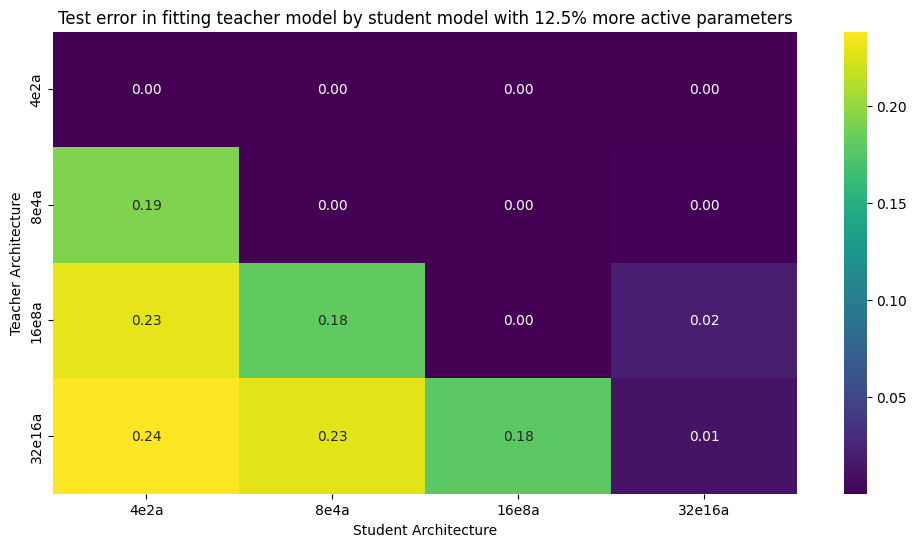

In [51]:
# Factor of 1.125 overparametrization in student model
d = 256
active_neurons1 = 256
active_neurons2 = 288

batch_size = 2048
num_epochs = 100
trial = 0
generate_srun = False
data_dict = {}
for num_experts2, k2 in [(32,16), (4,2), (8,4), (16,8)]:
    for num_experts1, k1 in [(4,2), (8,4), (16,8), (32,16)]:
        vals_lr = {}
        for lr in [1e-3, 1e-2]:
            vals_lr[lr] = []
            for trial in range(1):
                if generate_srun:
                    print(f'srun python moe_student_teacher.py --d {d} \
                        --k1 {k1} --num_experts1 {num_experts1} --active_neurons1 {active_neurons1} \
                        --k2 {k2} --num_experts2 {num_experts2} --active_neurons2 {active_neurons2} \
                        --num_epochs {num_epochs} \
                        --lr {lr} \
                        --batch_size {batch_size} \
                        --trial {trial}')
                else:
                    datum = generate_datapoint(d,
                                    k1,num_experts1,active_neurons1,
                                    k2,num_experts2,active_neurons2,
                                    num_epochs,lr,batch_size,
                                    trial=0)
                    val = datum['test_losses'][-1] / datum['base_losses'][-1]
                    vals_lr[lr].append(val)
        data_dict[((num_experts1,k1),(num_experts2,k2))] = vals_lr


import seaborn as sns
import pandas as pd
import numpy as np

print(data_dict)
processed_data_dict = {}
for k in data_dict.keys():
    bestmean = float('inf')
    for lr in data_dict[k].keys():
        if sum(data_dict[k][lr]) / len(data_dict[k][lr]) < bestmean:
            bestmean = sum(data_dict[k][lr]) / len(data_dict[k][lr])
    processed_data_dict[k] = bestmean


student_labels = [(4,2), (8,4), (16,8), (32,16)]
teacher_labels = [(4,2), (8,4), (16,8), (32,16)]
raw_data = np.zeros((len(student_labels), len(teacher_labels)))
for i, student in enumerate(student_labels):
    for j, teacher in enumerate(teacher_labels):
        if (teacher, student) in processed_data_dict.keys():
            raw_data[i,j] = processed_data_dict[(teacher, student)]
        else:
            raw_data[i,j] = float('inf')

print(raw_data)


import matplotlib.pyplot as plt

# Convert raw_data into a DataFrame for heatmap plotting
heatmap_df = pd.DataFrame(raw_data, index=[f'{label[0]}e{label[1]}a' for label in student_labels], columns=[f'{label[0]}e{label[1]}a' for label in teacher_labels])

print(heatmap_df)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_df.T, annot=True, fmt=".2f", cmap="viridis") # , cbar_kws={'label': 'Test error'}
plt.title("Test error in fitting teacher model by student model with 12.5% more active parameters")
plt.xlabel("Student Architecture")
plt.ylabel("Teacher Architecture")
plt.gcf().set_size_inches(12, 6)
plt.show()





# Sparsity 0.25, d = active neurons. 25% overparametrized student

Experiment file experiment_data/d256_16e4a256s_16e4a288s_lr0.001_b2048_e100_trial0.pkl already exists. Loading data.
Experiment file experiment_data/d256_16e4a256s_16e4a288s_lr0.01_b2048_e100_trial0.pkl already exists. Loading data.
Experiment file experiment_data/d256_8e2a256s_16e4a288s_lr0.001_b2048_e100_trial0.pkl already exists. Loading data.
Experiment file experiment_data/d256_8e2a256s_16e4a288s_lr0.01_b2048_e100_trial0.pkl already exists. Loading data.
Experiment file experiment_data/d256_16e4a256s_8e2a288s_lr0.001_b2048_e100_trial0.pkl already exists. Loading data.
Experiment file experiment_data/d256_16e4a256s_8e2a288s_lr0.01_b2048_e100_trial0.pkl already exists. Loading data.
Experiment file experiment_data/d256_8e2a256s_8e2a288s_lr0.001_b2048_e100_trial0.pkl already exists. Loading data.
Experiment file experiment_data/d256_8e2a256s_8e2a288s_lr0.01_b2048_e100_trial0.pkl already exists. Loading data.
{((16, 4), (16, 4)): {0.001: [0.0020352033567345605], 0.01: [0.0008386777064

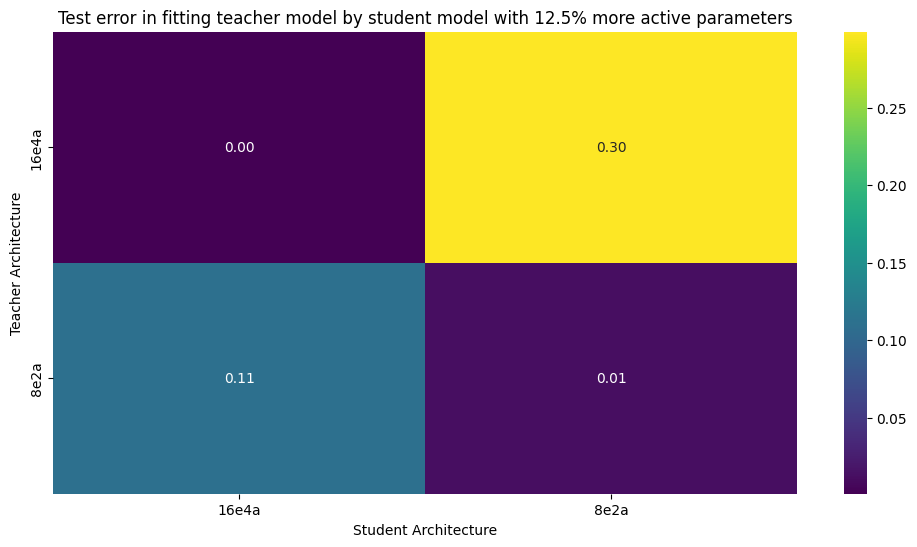

In [55]:
# Factor of 1.125 overparametrization in student model
d = 256
active_neurons1 = 256
active_neurons2 = 288

batch_size = 2048
num_epochs = 100
trial = 0
generate_srun = False
data_dict = {}
# for num_experts2, k2 in [(64,16),(32,8), (16,4), (8,2)]:
#     for num_experts1, k1 in [(64,16),(32,8),(16,4),(8,2)]:
for num_experts2, k2 in [(16,4),(8,2)]:
    for num_experts1, k1 in [(16,4),(8,2)]:
        vals_lr = {}
        for lr in [1e-3, 1e-2]:
            vals_lr[lr] = []
            for trial in range(1):
                if generate_srun:
                    print(f'srun python moe_student_teacher.py --d {d} \
                        --k1 {k1} --num_experts1 {num_experts1} --active_neurons1 {active_neurons1} \
                        --k2 {k2} --num_experts2 {num_experts2} --active_neurons2 {active_neurons2} \
                        --num_epochs {num_epochs} \
                        --lr {lr} \
                        --batch_size {batch_size} \
                        --trial {trial}')
                else:
                    datum = generate_datapoint(d,
                                    k1,num_experts1,active_neurons1,
                                    k2,num_experts2,active_neurons2,
                                    num_epochs,lr,batch_size,
                                    trial=0)
                    val = datum['test_losses'][-1] / datum['base_losses'][-1]
                    vals_lr[lr].append(val)
        data_dict[((num_experts1,k1),(num_experts2,k2))] = vals_lr


import seaborn as sns
import pandas as pd
import numpy as np

print(data_dict)
processed_data_dict = {}
for k in data_dict.keys():
    bestmean = float('inf')
    for lr in data_dict[k].keys():
        if sum(data_dict[k][lr]) / len(data_dict[k][lr]) < bestmean:
            bestmean = sum(data_dict[k][lr]) / len(data_dict[k][lr])
    processed_data_dict[k] = bestmean


student_labels = [(16,4),(8,2)]
teacher_labels = [(16,4),(8,2)]
raw_data = np.zeros((len(student_labels), len(teacher_labels)))
for i, student in enumerate(student_labels):
    for j, teacher in enumerate(teacher_labels):
        if (teacher, student) in processed_data_dict.keys():
            raw_data[i,j] = processed_data_dict[(teacher, student)]
        else:
            raw_data[i,j] = float('inf')

print(raw_data)


import matplotlib.pyplot as plt

# Convert raw_data into a DataFrame for heatmap plotting
heatmap_df = pd.DataFrame(raw_data, index=[f'{label[0]}e{label[1]}a' for label in student_labels], columns=[f'{label[0]}e{label[1]}a' for label in teacher_labels])

print(heatmap_df)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_df.T, annot=True, fmt=".2f", cmap="viridis") # , cbar_kws={'label': 'Test error'}
plt.title("Test error in fitting teacher model by student model with 12.5% more active parameters")
plt.xlabel("Student Architecture")
plt.ylabel("Teacher Architecture")
plt.gcf().set_size_inches(12, 6)
plt.show()





# Teacher granularity 8, student granularity 2 with increasing numbers of experts, d = active neurons. 25% overparametrized active student

In [ ]:
# Factor of 1.125 overparametrization in student model
d = 256
active_neurons1 = 256
active_neurons2 = 320

batch_size = 2048
num_epochs = 100
trial = 0
generate_srun = False
data_dict = {}
# for num_experts2, k2 in [(64,16),(32,8), (16,4), (8,2)]:
#     for num_experts1, k1 in [(64,16),(32,8),(16,4),(8,2)]:
for num_experts2, k2 in [(128,2),(64,2),(32,2),(16,2),(8,2),(4,2),(64,4),(32,4),(16,4),(8,4)]:
    for num_experts1, k1 in [(16,8)]:
        vals_lr = {}
        for lr in [1e-3, 1e-2]:
            vals_lr[lr] = []
            for trial in range(1):
                if generate_srun:
                    print(f'srun python moe_student_teacher.py --d {d} \
                        --k1 {k1} --num_experts1 {num_experts1} --active_neurons1 {active_neurons1} \
                        --k2 {k2} --num_experts2 {num_experts2} --active_neurons2 {active_neurons2} \
                        --num_epochs {num_epochs} \
                        --lr {lr} \
                        --batch_size {batch_size} \
                        --trial {trial}')
                else:
                    datum = generate_datapoint(d,
                                    k1,num_experts1,active_neurons1,
                                    k2,num_experts2,active_neurons2,
                                    num_epochs,lr,batch_size,
                                    trial=0)
                    val = datum['test_losses'][-1] / datum['base_losses'][-1]
                    vals_lr[lr].append(val)
        data_dict[((num_experts1,k1),(num_experts2,k2))] = vals_lr


import seaborn as sns
import pandas as pd
import numpy as np

print(data_dict)
processed_data_dict = {}
for k in data_dict.keys():
    bestmean = float('inf')
    for lr in data_dict[k].keys():
        if sum(data_dict[k][lr]) / len(data_dict[k][lr]) < bestmean:
            bestmean = sum(data_dict[k][lr]) / len(data_dict[k][lr])
    processed_data_dict[k] = bestmean


student_labels = [(128,2),(64,2),(32,2),(16,2),(8,2),(4,2),(64,4),(32,4),(16,4),(8,4)]
teacher_labels = [(16,8)]
raw_data = np.zeros((len(student_labels), len(teacher_labels)))
for i, student in enumerate(student_labels):
    for j, teacher in enumerate(teacher_labels):
        print((student,teacher))
        if (teacher, student) in processed_data_dict.keys():
            raw_data[i,j] = processed_data_dict[(teacher, student)]
        else:
            raw_data[i,j] = float('inf')

print(raw_data)


import matplotlib.pyplot as plt

# Convert raw_data into a DataFrame for heatmap plotting
heatmap_df = pd.DataFrame(raw_data, index=[f'{label[0]}e{label[1]}a' for label in student_labels], columns=[f'{label[0]}e{label[1]}a' for label in teacher_labels])

print(heatmap_df)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_df.T, annot=True, fmt=".2f", cmap="viridis") # , cbar_kws={'label': 'Test error'}
plt.title("Fitting teacher model with larger students that have roughly the same number of active neurons")
plt.xlabel("Student Architecture")
plt.ylabel("Teacher Architecture")
plt.gcf().set_size_inches(12, 6)
plt.show()





Generating teacher model with 8 / 16 experts and 256 active neurons
Training student model with 2 / 128 experts and 320 active neurons


  0%|                                                                                                                                                                             | 0/100 [00:00<?, ?it/s]

Generating train and test for epoch 0


  1%|█▋                                                                                                                                                                   | 1/100 [00:06<10:51,  6.58s/it]

Epoch [1/100], Train Loss: 1.9379, Test Loss: 1.9374, Base Loss: 2.3876
Generating train and test for epoch 1


  2%|███▎                                                                                                                                                                 | 2/100 [00:13<10:52,  6.65s/it]

Epoch [2/100], Train Loss: 1.3853, Test Loss: 1.3746, Base Loss: 2.3844
Generating train and test for epoch 2


  3%|████▉                                                                                                                                                                | 3/100 [00:19<10:33,  6.53s/it]

Epoch [3/100], Train Loss: 1.0965, Test Loss: 1.0928, Base Loss: 2.3816
Generating train and test for epoch 3


In [ ]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt



# Convert processed_data_dict to a DataFrame
data = []
for key, value in processed_data_dict.items():
    data.append({
        'Teacher': str(key[0]),
        'Student': str(key[1]),
        'Best Mean': value
    })

df = pd.DataFrame(data)



# # Create a pivot table for the heatmap
# heatmap_data = df.pivot("Teacher", "Student", "Best Mean")

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df, annot=True, fmt=".2e", cmap="viridis", cbar_kws={'label': 'Best Mean'})
plt.title("Heatmap of Best Mean Values")
plt.xlabel("Student")
plt.ylabel("Teacher")
plt.show()

ValueError: could not convert string to float: '(4, 2)'

<Figure size 1000x800 with 0 Axes>

In [5]:
# Factor of 1.125 overparametrization in student model
d = 256
active_neurons1 = 256
active_neurons2 = 288

batch_size = 2048
lr = 1e-3
num_epochs = 100
for num_experts1, k1 in [(4,2), (8,4), (16,8), (32,16)]:
    for num_experts2, k2 in [(4,2), (8,4), (16,8), (32,16)]:
        datum = generate_datapoint(d,
                        k1,num_experts1,active_neurons1,
                        k2,num_experts2,active_neurons2,
                        num_epochs,lr,batch_size,
                        trial=0)
        print(datum['test_losses'][-1])
        print(datum['base_losses'][-1])

Experiment file experiment_data/d256_4e2a256s_4e2a288s_lr0.001_b2048_e100_trial0.pkl already exists. Loading data.
0.00022366150551533792
7.8954386711120605
Experiment file experiment_data/d256_4e2a256s_8e4a288s_lr0.001_b2048_e100_trial0.pkl already exists. Loading data.
0.0016672256699621357
7.770959854125977
Experiment file experiment_data/d256_4e2a256s_16e8a288s_lr0.001_b2048_e100_trial0.pkl already exists. Loading data.
0.13490355014801025
7.759546995162964
Experiment file experiment_data/d256_4e2a256s_32e16a288s_lr0.001_b2048_e100_trial0.pkl already exists. Loading data.
0.7141218185424805
8.130845069885254
Generating teacher model with 4 / 8 experts and 256 active neurons
Training student model with 2 / 4 experts and 288 active neurons


  0%|                                                                                                                                  | 0/100 [00:00<?, ?it/s]

Generating train and test for epoch 0


  1%|█▏                                                                                                                        | 1/100 [00:02<03:24,  2.06s/it]

Epoch [1/100], Train Loss: 2.4137, Test Loss: 2.3969, Base Loss: 4.3399
Generating train and test for epoch 1


  2%|██▍                                                                                                                       | 2/100 [00:04<03:22,  2.06s/it]

Epoch [2/100], Train Loss: 1.9145, Test Loss: 1.9138, Base Loss: 4.3337
Generating train and test for epoch 2


  3%|███▋                                                                                                                      | 3/100 [00:06<03:20,  2.06s/it]

Epoch [3/100], Train Loss: 1.6730, Test Loss: 1.6653, Base Loss: 4.3477
Generating train and test for epoch 3


  4%|████▉                                                                                                                     | 4/100 [00:08<03:20,  2.09s/it]

Epoch [4/100], Train Loss: 1.5238, Test Loss: 1.5230, Base Loss: 4.3564
Generating train and test for epoch 4


  5%|██████                                                                                                                    | 5/100 [00:10<03:14,  2.05s/it]

Epoch [5/100], Train Loss: 1.4397, Test Loss: 1.4376, Base Loss: 4.3393
Generating train and test for epoch 5


  6%|███████▎                                                                                                                  | 6/100 [00:12<03:15,  2.08s/it]

Epoch [6/100], Train Loss: 1.3700, Test Loss: 1.3698, Base Loss: 4.3407
Generating train and test for epoch 6


  7%|████████▌                                                                                                                 | 7/100 [00:14<03:10,  2.05s/it]

Epoch [7/100], Train Loss: 1.3391, Test Loss: 1.3330, Base Loss: 4.3573
Generating train and test for epoch 7


  8%|█████████▊                                                                                                                | 8/100 [00:16<03:11,  2.08s/it]

Epoch [8/100], Train Loss: 1.3000, Test Loss: 1.3020, Base Loss: 4.4076
Generating train and test for epoch 8


  9%|██████████▉                                                                                                               | 9/100 [00:18<03:06,  2.05s/it]

Epoch [9/100], Train Loss: 1.2631, Test Loss: 1.2724, Base Loss: 4.3519
Generating train and test for epoch 9


 10%|████████████                                                                                                             | 10/100 [00:20<03:06,  2.08s/it]

Epoch [10/100], Train Loss: 1.2218, Test Loss: 1.2288, Base Loss: 4.3521
Generating train and test for epoch 10


 11%|█████████████▎                                                                                                           | 11/100 [00:22<03:01,  2.04s/it]

Epoch [11/100], Train Loss: 1.2173, Test Loss: 1.2008, Base Loss: 4.3271
Generating train and test for epoch 11


 12%|██████████████▌                                                                                                          | 12/100 [00:24<03:02,  2.07s/it]

Epoch [12/100], Train Loss: 1.1769, Test Loss: 1.1897, Base Loss: 4.3856
Generating train and test for epoch 12


 13%|███████████████▋                                                                                                         | 13/100 [00:26<02:57,  2.04s/it]

Epoch [13/100], Train Loss: 1.1598, Test Loss: 1.1534, Base Loss: 4.3596
Generating train and test for epoch 13


 14%|████████████████▉                                                                                                        | 14/100 [00:28<02:58,  2.08s/it]

Epoch [14/100], Train Loss: 1.1218, Test Loss: 1.1322, Base Loss: 4.3262
Generating train and test for epoch 14


 15%|██████████████████▏                                                                                                      | 15/100 [00:30<02:53,  2.04s/it]

Epoch [15/100], Train Loss: 1.1036, Test Loss: 1.0947, Base Loss: 4.3176
Generating train and test for epoch 15


 16%|███████████████████▎                                                                                                     | 16/100 [00:33<02:54,  2.08s/it]

Epoch [16/100], Train Loss: 1.0748, Test Loss: 1.0677, Base Loss: 4.3394
Generating train and test for epoch 16


 17%|████████████████████▌                                                                                                    | 17/100 [00:35<02:49,  2.05s/it]

Epoch [17/100], Train Loss: 1.0523, Test Loss: 1.0632, Base Loss: 4.3673
Generating train and test for epoch 17


 18%|█████████████████████▊                                                                                                   | 18/100 [00:37<02:49,  2.07s/it]

Epoch [18/100], Train Loss: 1.0395, Test Loss: 1.0476, Base Loss: 4.3662
Generating train and test for epoch 18


 19%|██████████████████████▉                                                                                                  | 19/100 [00:39<02:45,  2.04s/it]

Epoch [19/100], Train Loss: 1.0321, Test Loss: 1.0135, Base Loss: 4.3334
Generating train and test for epoch 19


 20%|████████████████████████▏                                                                                                | 20/100 [00:41<02:45,  2.07s/it]

Epoch [20/100], Train Loss: 0.9991, Test Loss: 1.0031, Base Loss: 4.3389
Generating train and test for epoch 20


 21%|█████████████████████████▍                                                                                               | 21/100 [00:43<02:41,  2.04s/it]

Epoch [21/100], Train Loss: 1.0067, Test Loss: 0.9863, Base Loss: 4.3513
Generating train and test for epoch 21


 22%|██████████████████████████▌                                                                                              | 22/100 [00:45<02:41,  2.07s/it]

Epoch [22/100], Train Loss: 0.9810, Test Loss: 0.9753, Base Loss: 4.3786
Generating train and test for epoch 22


 23%|███████████████████████████▊                                                                                             | 23/100 [00:47<02:37,  2.04s/it]

Epoch [23/100], Train Loss: 0.9639, Test Loss: 0.9677, Base Loss: 4.3543
Generating train and test for epoch 23


 24%|█████████████████████████████                                                                                            | 24/100 [00:49<02:37,  2.07s/it]

Epoch [24/100], Train Loss: 0.9749, Test Loss: 0.9688, Base Loss: 4.3528
Generating train and test for epoch 24


 25%|██████████████████████████████▎                                                                                          | 25/100 [00:51<02:33,  2.04s/it]

Epoch [25/100], Train Loss: 0.9643, Test Loss: 0.9437, Base Loss: 4.3491
Generating train and test for epoch 25


 26%|███████████████████████████████▍                                                                                         | 26/100 [00:53<02:33,  2.07s/it]

Epoch [26/100], Train Loss: 0.9357, Test Loss: 0.9378, Base Loss: 4.3598
Generating train and test for epoch 26


 27%|████████████████████████████████▋                                                                                        | 27/100 [00:55<02:29,  2.04s/it]

Epoch [27/100], Train Loss: 0.9469, Test Loss: 0.9278, Base Loss: 4.3616
Generating train and test for epoch 27


 28%|█████████████████████████████████▉                                                                                       | 28/100 [00:57<02:29,  2.07s/it]

Epoch [28/100], Train Loss: 0.9236, Test Loss: 0.9300, Base Loss: 4.3346
Generating train and test for epoch 28


 29%|███████████████████████████████████                                                                                      | 29/100 [00:59<02:24,  2.04s/it]

Epoch [29/100], Train Loss: 0.9191, Test Loss: 0.9182, Base Loss: 4.3868
Generating train and test for epoch 29


 30%|████████████████████████████████████▎                                                                                    | 30/100 [01:01<02:25,  2.07s/it]

Epoch [30/100], Train Loss: 0.9271, Test Loss: 0.9114, Base Loss: 4.3543
Generating train and test for epoch 30


 31%|█████████████████████████████████████▌                                                                                   | 31/100 [01:03<02:22,  2.07s/it]

Epoch [31/100], Train Loss: 0.9030, Test Loss: 0.9133, Base Loss: 4.3502
Generating train and test for epoch 31


 32%|██████████████████████████████████████▋                                                                                  | 32/100 [01:05<02:20,  2.06s/it]

Epoch [32/100], Train Loss: 0.8887, Test Loss: 0.9040, Base Loss: 4.3600
Generating train and test for epoch 32


 33%|███████████████████████████████████████▉                                                                                 | 33/100 [01:08<02:18,  2.06s/it]

Epoch [33/100], Train Loss: 0.8948, Test Loss: 0.9020, Base Loss: 4.3672
Generating train and test for epoch 33


 34%|█████████████████████████████████████████▏                                                                               | 34/100 [01:10<02:16,  2.06s/it]

Epoch [34/100], Train Loss: 0.9054, Test Loss: 0.8839, Base Loss: 4.3245
Generating train and test for epoch 34


 35%|██████████████████████████████████████████▎                                                                              | 35/100 [01:12<02:13,  2.06s/it]

Epoch [35/100], Train Loss: 0.8816, Test Loss: 0.8997, Base Loss: 4.3517
Generating train and test for epoch 35


 36%|███████████████████████████████████████████▌                                                                             | 36/100 [01:14<02:11,  2.06s/it]

Epoch [36/100], Train Loss: 0.8838, Test Loss: 0.8795, Base Loss: 4.3291
Generating train and test for epoch 36


 37%|████████████████████████████████████████████▊                                                                            | 37/100 [01:16<02:09,  2.06s/it]

Epoch [37/100], Train Loss: 0.9040, Test Loss: 0.8745, Base Loss: 4.3195
Generating train and test for epoch 37


 38%|█████████████████████████████████████████████▉                                                                           | 38/100 [01:18<02:09,  2.08s/it]

Epoch [38/100], Train Loss: 0.8683, Test Loss: 0.8886, Base Loss: 4.3811
Generating train and test for epoch 38


 39%|███████████████████████████████████████████████▏                                                                         | 39/100 [01:20<02:05,  2.06s/it]

Epoch [39/100], Train Loss: 0.8864, Test Loss: 0.8905, Base Loss: 4.3461
Generating train and test for epoch 39


 40%|████████████████████████████████████████████████▍                                                                        | 40/100 [01:22<02:04,  2.08s/it]

Epoch [40/100], Train Loss: 0.8896, Test Loss: 0.8789, Base Loss: 4.3543
Generating train and test for epoch 40


 41%|█████████████████████████████████████████████████▌                                                                       | 41/100 [01:24<02:00,  2.05s/it]

Epoch [41/100], Train Loss: 0.8758, Test Loss: 0.8741, Base Loss: 4.3421
Generating train and test for epoch 41


 42%|██████████████████████████████████████████████████▊                                                                      | 42/100 [01:26<02:00,  2.08s/it]

Epoch [42/100], Train Loss: 0.8635, Test Loss: 0.8751, Base Loss: 4.3463
Generating train and test for epoch 42


 43%|████████████████████████████████████████████████████                                                                     | 43/100 [01:28<01:56,  2.05s/it]

Epoch [43/100], Train Loss: 0.8848, Test Loss: 0.8765, Base Loss: 4.3552
Generating train and test for epoch 43


 44%|█████████████████████████████████████████████████████▏                                                                   | 44/100 [01:30<01:56,  2.07s/it]

Epoch [44/100], Train Loss: 0.8721, Test Loss: 0.8768, Base Loss: 4.3333
Generating train and test for epoch 44


 45%|██████████████████████████████████████████████████████▍                                                                  | 45/100 [01:32<01:52,  2.05s/it]

Epoch [45/100], Train Loss: 0.8697, Test Loss: 0.8793, Base Loss: 4.3350
Generating train and test for epoch 45


 46%|███████████████████████████████████████████████████████▋                                                                 | 46/100 [01:34<01:51,  2.07s/it]

Epoch [46/100], Train Loss: 0.8805, Test Loss: 0.8809, Base Loss: 4.3503
Generating train and test for epoch 46


 47%|████████████████████████████████████████████████████████▊                                                                | 47/100 [01:36<01:48,  2.04s/it]

Epoch [47/100], Train Loss: 0.8866, Test Loss: 0.8623, Base Loss: 4.3705
Generating train and test for epoch 47


 48%|██████████████████████████████████████████████████████████                                                               | 48/100 [01:38<01:47,  2.07s/it]

Epoch [48/100], Train Loss: 0.8820, Test Loss: 0.8769, Base Loss: 4.3515
Generating train and test for epoch 48


 49%|███████████████████████████████████████████████████████████▎                                                             | 49/100 [01:40<01:44,  2.04s/it]

Epoch [49/100], Train Loss: 0.8618, Test Loss: 0.8569, Base Loss: 4.3418
Generating train and test for epoch 49


 50%|████████████████████████████████████████████████████████████▌                                                            | 50/100 [01:43<01:43,  2.07s/it]

Epoch [50/100], Train Loss: 0.8723, Test Loss: 0.8754, Base Loss: 4.3634
Generating train and test for epoch 50


 51%|█████████████████████████████████████████████████████████████▋                                                           | 51/100 [01:45<01:39,  2.04s/it]

Epoch [51/100], Train Loss: 0.8677, Test Loss: 0.8616, Base Loss: 4.3645
Generating train and test for epoch 51


 52%|██████████████████████████████████████████████████████████████▉                                                          | 52/100 [01:47<01:39,  2.07s/it]

Epoch [52/100], Train Loss: 0.8727, Test Loss: 0.8717, Base Loss: 4.3462
Generating train and test for epoch 52


 53%|████████████████████████████████████████████████████████████████▏                                                        | 53/100 [01:49<01:35,  2.04s/it]

Epoch [53/100], Train Loss: 0.8751, Test Loss: 0.8659, Base Loss: 4.3593
Generating train and test for epoch 53


 54%|█████████████████████████████████████████████████████████████████▎                                                       | 54/100 [01:51<01:35,  2.07s/it]

Epoch [54/100], Train Loss: 0.8711, Test Loss: 0.8653, Base Loss: 4.3676
Generating train and test for epoch 54


 55%|██████████████████████████████████████████████████████████████████▌                                                      | 55/100 [01:53<01:31,  2.04s/it]

Epoch [55/100], Train Loss: 0.8699, Test Loss: 0.8555, Base Loss: 4.3449
Generating train and test for epoch 55


 56%|███████████████████████████████████████████████████████████████████▊                                                     | 56/100 [01:55<01:31,  2.07s/it]

Epoch [56/100], Train Loss: 0.8513, Test Loss: 0.8719, Base Loss: 4.3391
Generating train and test for epoch 56


 57%|████████████████████████████████████████████████████████████████████▉                                                    | 57/100 [01:57<01:27,  2.04s/it]

Epoch [57/100], Train Loss: 0.8466, Test Loss: 0.8652, Base Loss: 4.3342
Generating train and test for epoch 57


 58%|██████████████████████████████████████████████████████████████████████▏                                                  | 58/100 [01:59<01:26,  2.07s/it]

Epoch [58/100], Train Loss: 0.8803, Test Loss: 0.8696, Base Loss: 4.3553
Generating train and test for epoch 58


 59%|███████████████████████████████████████████████████████████████████████▍                                                 | 59/100 [02:01<01:23,  2.04s/it]

Epoch [59/100], Train Loss: 0.8558, Test Loss: 0.8699, Base Loss: 4.3473
Generating train and test for epoch 59


 60%|████████████████████████████████████████████████████████████████████████▌                                                | 60/100 [02:03<01:22,  2.07s/it]

Epoch [60/100], Train Loss: 0.8449, Test Loss: 0.8716, Base Loss: 4.3643
Generating train and test for epoch 60


 61%|█████████████████████████████████████████████████████████████████████████▊                                               | 61/100 [02:05<01:19,  2.04s/it]

Epoch [61/100], Train Loss: 0.8666, Test Loss: 0.8600, Base Loss: 4.3472
Generating train and test for epoch 61


 62%|███████████████████████████████████████████████████████████████████████████                                              | 62/100 [02:07<01:18,  2.07s/it]

Epoch [62/100], Train Loss: 0.8548, Test Loss: 0.8509, Base Loss: 4.3272
Generating train and test for epoch 62


 63%|████████████████████████████████████████████████████████████████████████████▏                                            | 63/100 [02:09<01:15,  2.04s/it]

Epoch [63/100], Train Loss: 0.8810, Test Loss: 0.8506, Base Loss: 4.3203
Generating train and test for epoch 63


 64%|█████████████████████████████████████████████████████████████████████████████▍                                           | 64/100 [02:11<01:14,  2.07s/it]

Epoch [64/100], Train Loss: 0.8683, Test Loss: 0.8633, Base Loss: 4.3537
Generating train and test for epoch 64


 65%|██████████████████████████████████████████████████████████████████████████████▋                                          | 65/100 [02:13<01:11,  2.04s/it]

Epoch [65/100], Train Loss: 0.8804, Test Loss: 0.8651, Base Loss: 4.3510
Generating train and test for epoch 65


 66%|███████████████████████████████████████████████████████████████████████████████▊                                         | 66/100 [02:15<01:10,  2.07s/it]

Epoch [66/100], Train Loss: 0.8491, Test Loss: 0.8617, Base Loss: 4.3479
Generating train and test for epoch 66


 67%|█████████████████████████████████████████████████████████████████████████████████                                        | 67/100 [02:17<01:07,  2.04s/it]

Epoch [67/100], Train Loss: 0.8342, Test Loss: 0.8543, Base Loss: 4.3429
Generating train and test for epoch 67


 68%|██████████████████████████████████████████████████████████████████████████████████▎                                      | 68/100 [02:20<01:06,  2.07s/it]

Epoch [68/100], Train Loss: 0.8482, Test Loss: 0.8672, Base Loss: 4.3550
Generating train and test for epoch 68


 69%|███████████████████████████████████████████████████████████████████████████████████▍                                     | 69/100 [02:22<01:03,  2.04s/it]

Epoch [69/100], Train Loss: 0.8481, Test Loss: 0.8575, Base Loss: 4.3403
Generating train and test for epoch 69


 70%|████████████████████████████████████████████████████████████████████████████████████▋                                    | 70/100 [02:24<01:02,  2.07s/it]

Epoch [70/100], Train Loss: 0.8722, Test Loss: 0.8454, Base Loss: 4.3188
Generating train and test for epoch 70


 71%|█████████████████████████████████████████████████████████████████████████████████████▉                                   | 71/100 [02:26<00:59,  2.04s/it]

Epoch [71/100], Train Loss: 0.8492, Test Loss: 0.8527, Base Loss: 4.3307
Generating train and test for epoch 71


 72%|███████████████████████████████████████████████████████████████████████████████████████                                  | 72/100 [02:28<00:57,  2.07s/it]

Epoch [72/100], Train Loss: 0.8511, Test Loss: 0.8473, Base Loss: 4.3325
Generating train and test for epoch 72


 73%|████████████████████████████████████████████████████████████████████████████████████████▎                                | 73/100 [02:30<00:55,  2.04s/it]

Epoch [73/100], Train Loss: 0.8298, Test Loss: 0.8572, Base Loss: 4.3510
Generating train and test for epoch 73


 74%|█████████████████████████████████████████████████████████████████████████████████████████▌                               | 74/100 [02:32<00:53,  2.07s/it]

Epoch [74/100], Train Loss: 0.8362, Test Loss: 0.8481, Base Loss: 4.3439
Generating train and test for epoch 74


 75%|██████████████████████████████████████████████████████████████████████████████████████████▊                              | 75/100 [02:34<00:50,  2.04s/it]

Epoch [75/100], Train Loss: 0.8444, Test Loss: 0.8338, Base Loss: 4.3404
Generating train and test for epoch 75


 76%|███████████████████████████████████████████████████████████████████████████████████████████▉                             | 76/100 [02:36<00:49,  2.07s/it]

Epoch [76/100], Train Loss: 0.8458, Test Loss: 0.8559, Base Loss: 4.3414
Generating train and test for epoch 76


 77%|█████████████████████████████████████████████████████████████████████████████████████████████▏                           | 77/100 [02:38<00:46,  2.04s/it]

Epoch [77/100], Train Loss: 0.8539, Test Loss: 0.8543, Base Loss: 4.3671
Generating train and test for epoch 77


 78%|██████████████████████████████████████████████████████████████████████████████████████████████▍                          | 78/100 [02:40<00:45,  2.06s/it]

Epoch [78/100], Train Loss: 0.8502, Test Loss: 0.8472, Base Loss: 4.3498
Generating train and test for epoch 78


 79%|███████████████████████████████████████████████████████████████████████████████████████████████▌                         | 79/100 [02:42<00:42,  2.04s/it]

Epoch [79/100], Train Loss: 0.8441, Test Loss: 0.8563, Base Loss: 4.3879
Generating train and test for epoch 79


 80%|████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 80/100 [02:44<00:41,  2.06s/it]

Epoch [80/100], Train Loss: 0.8468, Test Loss: 0.8390, Base Loss: 4.3708
Generating train and test for epoch 80


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████                       | 81/100 [02:46<00:38,  2.04s/it]

Epoch [81/100], Train Loss: 0.8412, Test Loss: 0.8459, Base Loss: 4.3301
Generating train and test for epoch 81


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 82/100 [02:48<00:37,  2.06s/it]

Epoch [82/100], Train Loss: 0.8579, Test Loss: 0.8377, Base Loss: 4.3291
Generating train and test for epoch 82


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 83/100 [02:50<00:34,  2.04s/it]

Epoch [83/100], Train Loss: 0.8369, Test Loss: 0.8503, Base Loss: 4.3623
Generating train and test for epoch 83


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 84/100 [02:52<00:33,  2.06s/it]

Epoch [84/100], Train Loss: 0.8396, Test Loss: 0.8471, Base Loss: 4.3586
Generating train and test for epoch 84


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 85/100 [02:54<00:30,  2.04s/it]

Epoch [85/100], Train Loss: 0.8599, Test Loss: 0.8402, Base Loss: 4.3182
Generating train and test for epoch 85


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 86/100 [02:56<00:28,  2.06s/it]

Epoch [86/100], Train Loss: 0.8613, Test Loss: 0.8429, Base Loss: 4.3380
Generating train and test for epoch 86


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 87/100 [02:58<00:26,  2.03s/it]

Epoch [87/100], Train Loss: 0.8530, Test Loss: 0.8373, Base Loss: 4.3474
Generating train and test for epoch 87


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 88/100 [03:01<00:24,  2.06s/it]

Epoch [88/100], Train Loss: 0.8464, Test Loss: 0.8461, Base Loss: 4.3328
Generating train and test for epoch 88


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 89/100 [03:03<00:22,  2.03s/it]

Epoch [89/100], Train Loss: 0.8382, Test Loss: 0.8498, Base Loss: 4.3657
Generating train and test for epoch 89


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 90/100 [03:05<00:20,  2.06s/it]

Epoch [90/100], Train Loss: 0.8428, Test Loss: 0.8515, Base Loss: 4.3583
Generating train and test for epoch 90


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 91/100 [03:07<00:18,  2.03s/it]

Epoch [91/100], Train Loss: 0.8481, Test Loss: 0.8432, Base Loss: 4.3416
Generating train and test for epoch 91


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 92/100 [03:09<00:16,  2.06s/it]

Epoch [92/100], Train Loss: 0.8437, Test Loss: 0.8474, Base Loss: 4.3348
Generating train and test for epoch 92


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 93/100 [03:11<00:14,  2.06s/it]

Epoch [93/100], Train Loss: 0.8529, Test Loss: 0.8584, Base Loss: 4.3582
Generating train and test for epoch 93


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 94/100 [03:13<00:12,  2.06s/it]

Epoch [94/100], Train Loss: 0.8351, Test Loss: 0.8279, Base Loss: 4.3588
Generating train and test for epoch 94


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 95/100 [03:15<00:10,  2.06s/it]

Epoch [95/100], Train Loss: 0.8519, Test Loss: 0.8465, Base Loss: 4.3647
Generating train and test for epoch 95


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 96/100 [03:17<00:08,  2.05s/it]

Epoch [96/100], Train Loss: 0.8328, Test Loss: 0.8401, Base Loss: 4.3376
Generating train and test for epoch 96


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 97/100 [03:19<00:06,  2.05s/it]

Epoch [97/100], Train Loss: 0.8494, Test Loss: 0.8462, Base Loss: 4.3417
Generating train and test for epoch 97


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 98/100 [03:21<00:04,  2.05s/it]

Epoch [98/100], Train Loss: 0.8410, Test Loss: 0.8463, Base Loss: 4.3619
Generating train and test for epoch 98


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 99/100 [03:23<00:02,  2.05s/it]

Epoch [99/100], Train Loss: 0.8336, Test Loss: 0.8421, Base Loss: 4.3422
Generating train and test for epoch 99


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:25<00:00,  2.06s/it]


Epoch [100/100], Train Loss: 0.8347, Test Loss: 0.8399, Base Loss: 4.3638
0.8398547768592834
4.363753318786621
Generating teacher model with 4 / 8 experts and 256 active neurons
Training student model with 4 / 8 experts and 288 active neurons


  0%|                                                                                                                                  | 0/100 [00:00<?, ?it/s]

Generating train and test for epoch 0


  1%|█▏                                                                                                                        | 1/100 [00:02<03:37,  2.20s/it]

Epoch [1/100], Train Loss: 2.4171, Test Loss: 2.3983, Base Loss: 4.4207
Generating train and test for epoch 1


  1%|█▏                                                                                                                        | 1/100 [00:02<04:51,  2.94s/it]


KeyboardInterrupt: 